In [1]:
# Code to enable this notebook to import from libraries
import os
import sys
module_path = os.path.abspath(os.path.join('..\..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import csv
from scripts.mockUtilities import *
from scripts.utilities import *

In [3]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pywt
import pywt.data
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap
from scipy.sparse import csr_matrix
from scipy.io import mmread
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [4]:
# Set seed for reproducibility
np.random.seed(999)

## Functions for visualising embeddings

In [5]:
# Setup shared color scheme for layers
from matplotlib.colors import ListedColormap
layer_colors = ['blue', 'darkorange', 'red', 'saddlebrown', 'orchid', 'darkkhaki', 'aqua', 'white']
layers_cmap = ListedColormap(layer_colors)
layer_color_f = lambda i: layer_colors[i]

## Loading Data

In [6]:
counts = mmread(r'..\..\data\10x_visium_LIBD\sample9\counts_hvg.mtx')
counts_sct = mmread(r'..\..\data\10x_visium_LIBD\sample9\sct_transformed_counts.mtx')
coords = pd.read_csv(r'..\..\data\10x_visium_LIBD\sample9\coords.csv')
meta_data = pd.read_csv(r'..\..\data\10x_visium_LIBD\sample9\meta.csv')

In [7]:
coords = coords.rename(columns={'x_coord': 'x', 'y_coord': 'y'})

# Original counts; no normalization; no log, no sctransform
cell_feature_ori = counts
cell_feature_ori = (cell_feature_ori.toarray())
meta_data["feature_ori"] =  [cell_feature_ori[:,x] for x in range(meta_data.shape[0])] 

# This is log transformed counts, that is, log(counts + 1) (this +1 is typical practice to preserve 0 counts in log transformed data)
cell_feature_sct = counts_sct
cell_feature_sct = (cell_feature_sct.toarray())
meta_data["feature_sct"] =  [cell_feature_sct[:,x] for x in range(meta_data.shape[0])] 

meta_data = meta_data[['barcode', 'feature_sct', 'feature_ori', 'spatialLIBD']]
rna = pd.concat([coords, meta_data], axis=1)
rna['original index'] = rna.index
rna = rna.dropna()
rna['spatialLIBDCode'] = rna['spatialLIBD'].astype('category').cat.codes
rna = rna.reset_index(drop=True)

Text(0, 0.5, 'Vertical ordinate')

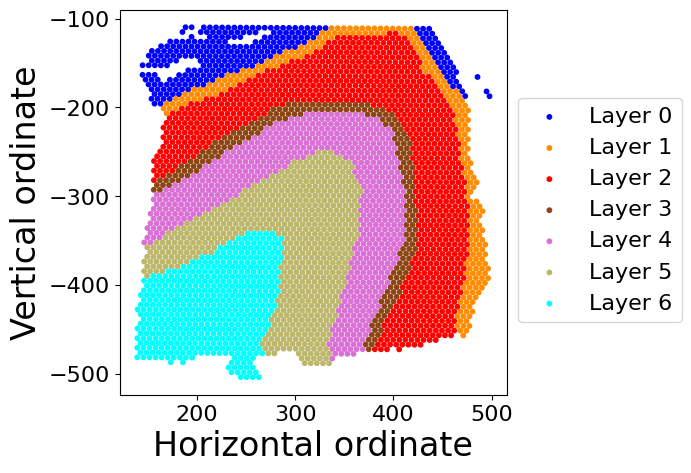

In [8]:
# Plot data
fig = plt.figure(figsize=(5, 5))

for layer in range(7):
  data = rna[rna['spatialLIBDCode'] == layer]
  plt.scatter(data['x'], data['y'], s=10, c=data['spatialLIBDCode'].apply(layer_color_f), label=f"Layer {layer}")
plt.legend(fontsize=16, bbox_to_anchor=(1.0,0.8))
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.gca().set_aspect('equal')
plt.xlabel("Horizontal ordinate", fontsize=24)
plt.ylabel("Vertical ordinate", fontsize=24)

In [9]:
# Set the settings for the data
N_GENES = len(rna["feature_sct"][0])

# Set the settings for the gridding of the data
MIN_X = 130
MAX_X = 500
MIN_Y = -510
MAX_Y = -100
N_X_INDICES = 2**6
N_Y_INDICES = N_X_INDICES
N_CELLS = N_X_INDICES * N_Y_INDICES

# Calculate the size of each cell in the grid
cell_size_x = (MAX_X - MIN_X) / N_X_INDICES
cell_size_y = (MAX_Y - MIN_Y) / N_Y_INDICES

# Assign each (x, y) point to a grid cell
rna['grid_x'] = ((rna['x'] - MIN_X) // cell_size_x).astype(int)
rna['grid_y'] = ((rna['y'] - MIN_Y) // cell_size_y).astype(int)

# Group by grid cells (grid_x, grid_y) and calculate the average feature vector for each cell
grouped = rna.groupby(['grid_y', 'grid_x'])['feature_sct'].apply(lambda x: np.mean(np.vstack(x), axis=0))
fill_feature_vector = np.zeros(N_GENES)
full_index = pd.MultiIndex.from_product([range(N_Y_INDICES), range(N_X_INDICES)], names=['y_index', 'x_index'])
grouped_reindexed = grouped.reindex(full_index, fill_value=fill_feature_vector)
grid_rna = pd.DataFrame(grouped_reindexed.tolist(), index=grouped_reindexed.index)

# Rename the columns to gene_indicator_n where n is the element index of the feature vector
grid_rna.columns = [f'gene_indicator_{i}' for i in range(grid_rna.shape[1])]

# Reset index to have y_index and x_index as named columns
grid_rna.index.names = ['y_index', 'x_index']

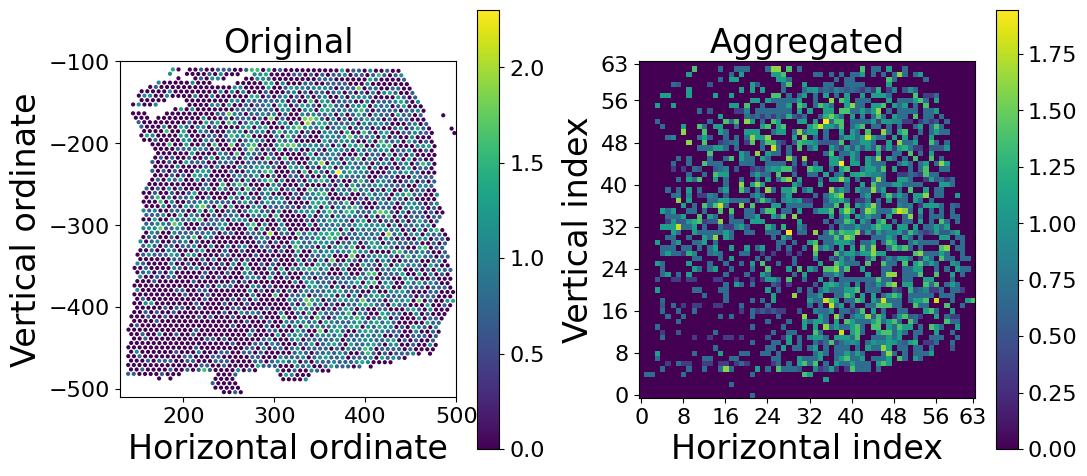

In [10]:
# Plot the original data vs grid aggregated data for a particular gene
gene_id = 43
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# Plot original data
scatter = axes[0].scatter(rna['x'], rna['y'], s=4, c=rna['feature_sct'].apply(lambda v: v[gene_id]), cmap='viridis')
cbar = fig.colorbar(scatter, ax=axes[0])
cbar.ax.tick_params(labelsize=16)
axes[0].set_aspect(0.9)
axes[0].set_xlabel('Horizontal ordinate', fontsize=24)
axes[0].set_ylabel('Vertical ordinate', fontsize=24)
axes[0].set_title('Original', fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].set_xlim((130,500))
axes[0].set_ylim((-510,-100))

# Plot aggregated data
aggregated_gene = grid_rna.iloc[:, gene_id].unstack(level='x_index')
x_ords = aggregated_gene.columns.values
y_ords = aggregated_gene.index.values
im = axes[1].imshow(aggregated_gene.values, cmap='viridis', aspect='equal', 
                    extent=[x_ords.min() - 0.5, x_ords.max() + 0.5,
                            y_ords.min() - 0.5, y_ords.max() + 0.5],
                    origin='lower')
cbar = fig.colorbar(im, ax=axes[1])
cbar.ax.tick_params(labelsize=16)
axes[1].set_xlabel('Horizontal index', fontsize=24)
axes[1].set_ylabel('Vertical index', fontsize=24)
axes[1].set_xticks(np.append(np.arange(x_ords.min(), x_ords.max() + 1, 8), x_ords.max()))
axes[1].set_yticks(np.append(np.arange(y_ords.min(), y_ords.max() + 1, 8), x_ords.max()))
axes[1].set_title('Aggregated', fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=16)

# Show the plot
plt.tight_layout()
plt.show()

## Loading inference results

In [11]:
def format_activities(df):
    grid_size = 64
    y_index, x_index = np.divmod(np.arange(grid_size * grid_size), grid_size)
    df.columns = [f'gene_indicator_{i}' for i in range(df.shape[1])]
    df.index = pd.MultiIndex.from_arrays([y_index, x_index], names=['y_index', 'x_index'])
    matrices = []
    for column in df.columns:
        matrix = df[column].unstack().values
        matrices.append(matrix)
    return matrices

In [12]:
# Loading inferred factor activites for waveST
waveST_L_0_threshold = format_activities(pd.read_csv('waveST0ThresholdVisium.csv', index_col=0))
waveST_L_hybrid = format_activities(pd.read_csv('waveSTHybridVisium.csv', index_col=0))
waveST_L_0_threshold_5 = format_activities(pd.read_csv('waveST0ThresholdVisium5.csv', index_col=0))
waveST_L_hybrid_5 = format_activities(pd.read_csv('waveSTHybridVisium5.csv', index_col=0))
waveST_L_0_threshold_6 = format_activities(pd.read_csv('waveST0ThresholdVisium6.csv', index_col=0))
waveST_L_hybrid_6 = format_activities(pd.read_csv('waveSTHybridVisium6.csv', index_col=0))

In [13]:
# Reading and loading data
loaded = np.load('L_pca.npz')
L_pca = [loaded[f'arr_{i}'] for i in range(len(loaded.files))]
loaded = np.load('idwt_L_means.npz')
idwt_L_means = [loaded[f'arr_{i}'] for i in range(len(loaded.files))]
loaded = np.load('F_means.npz')
F_means = [loaded[f'arr_{i}'] for i in range(len(loaded.files))]
loaded = np.load('F_pca.npz')
F_pca = [loaded[f'arr_{i}'] for i in range(len(loaded.files))]

In [14]:
N_FACTORS = len(waveST_L_0_threshold)
n_factors = N_FACTORS

## Factor matching

In [15]:
f_ord_waveST = (2,6,4,1,3,5,7)
f_ord_waveST_shift = [i-1 for i in f_ord_waveST]
f_ord_waveST_hyb = (2,7,4,1,3,5,6)
f_ord_waveST_hyb_shift = [i-1 for i in f_ord_waveST_hyb]
f_ord_waveST_5 = (2,6,4,1,3,5,7)
f_ord_waveST_5_shift = [i-1 for i in f_ord_waveST_5]
f_ord_waveST_5_hyb = (2,7,4,1,3,5,6)
f_ord_waveST_5_hyb_shift = [i-1 for i in f_ord_waveST_5_hyb]
f_ord_waveST_6 = (2,6,4,1,3,5,7)
f_ord_waveST_6_shift = [i-1 for i in f_ord_waveST_6]
f_ord_waveST_6_hyb = (2,7,4,1,3,5,6)
f_ord_waveST_6_hyb_shift = [i-1 for i in f_ord_waveST_6_hyb]

assert set(f_ord_waveST) == set(range(1,N_FACTORS+1))
assert set(f_ord_waveST_hyb) == set(range(1,N_FACTORS+1))
assert set(f_ord_waveST_5) == set(range(1,N_FACTORS+1))
assert set(f_ord_waveST_5_hyb) == set(range(1,N_FACTORS+1))
assert set(f_ord_waveST_6) == set(range(1,N_FACTORS+1))
assert set(f_ord_waveST_6_hyb) == set(range(1,N_FACTORS+1))

# Shifting order for L
waveST_L_0_threshold = [waveST_L_0_threshold[i] for i in f_ord_waveST_shift]
waveST_L_hybrid = [waveST_L_hybrid[i] for i in f_ord_waveST_hyb_shift]
waveST_L_0_threshold_5 = [waveST_L_0_threshold_5[i] for i in f_ord_waveST_5_shift]
waveST_L_hybrid_5 = [waveST_L_hybrid_5[i] for i in f_ord_waveST_5_hyb_shift]
waveST_L_0_threshold_6 = [waveST_L_0_threshold_6[i] for i in f_ord_waveST_6_shift]
waveST_L_hybrid_6 = [waveST_L_hybrid_6[i] for i in f_ord_waveST_6_hyb_shift]

In [16]:
factor_order_from_1 = (3,7,2,1,4,6,5)
factor_order = [i-1 for i in factor_order_from_1]
factor_order_from_1_pca = (2,6,4,1,3,5,7)
factor_order_pca = [i-1 for i in factor_order_from_1_pca]
assert set(factor_order_from_1) == set(range(1,N_FACTORS+1))
assert set(factor_order_from_1_pca) == set(range(1,N_FACTORS+1))

# Shifting order for L
idwt_L_means = [idwt_L_means[i] for i in factor_order]
F_means = [F_means[i] for i in factor_order]
L_pca = [L_pca[i] for i in factor_order_pca]
F_pca = [F_pca[i] for i in factor_order_pca]

## Comparing methods

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scripts.cavi_plot_utilities import *
from scripts.cavi import *
import copy
from scripts.cavi_utilities import *
from scripts.cavi_evaluation import *
from scripts.utilities import *

In [18]:
from IPython.display import display, HTML
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pywt
import pywt.data
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap
from scipy.sparse import csr_matrix
from scipy.io import mmread
from sklearn.mixture import GaussianMixture

%matplotlib inline

### Comparing inferred factor activities in the spatial domain

In [19]:
rb_centred_color_map = create_custom_colormap()

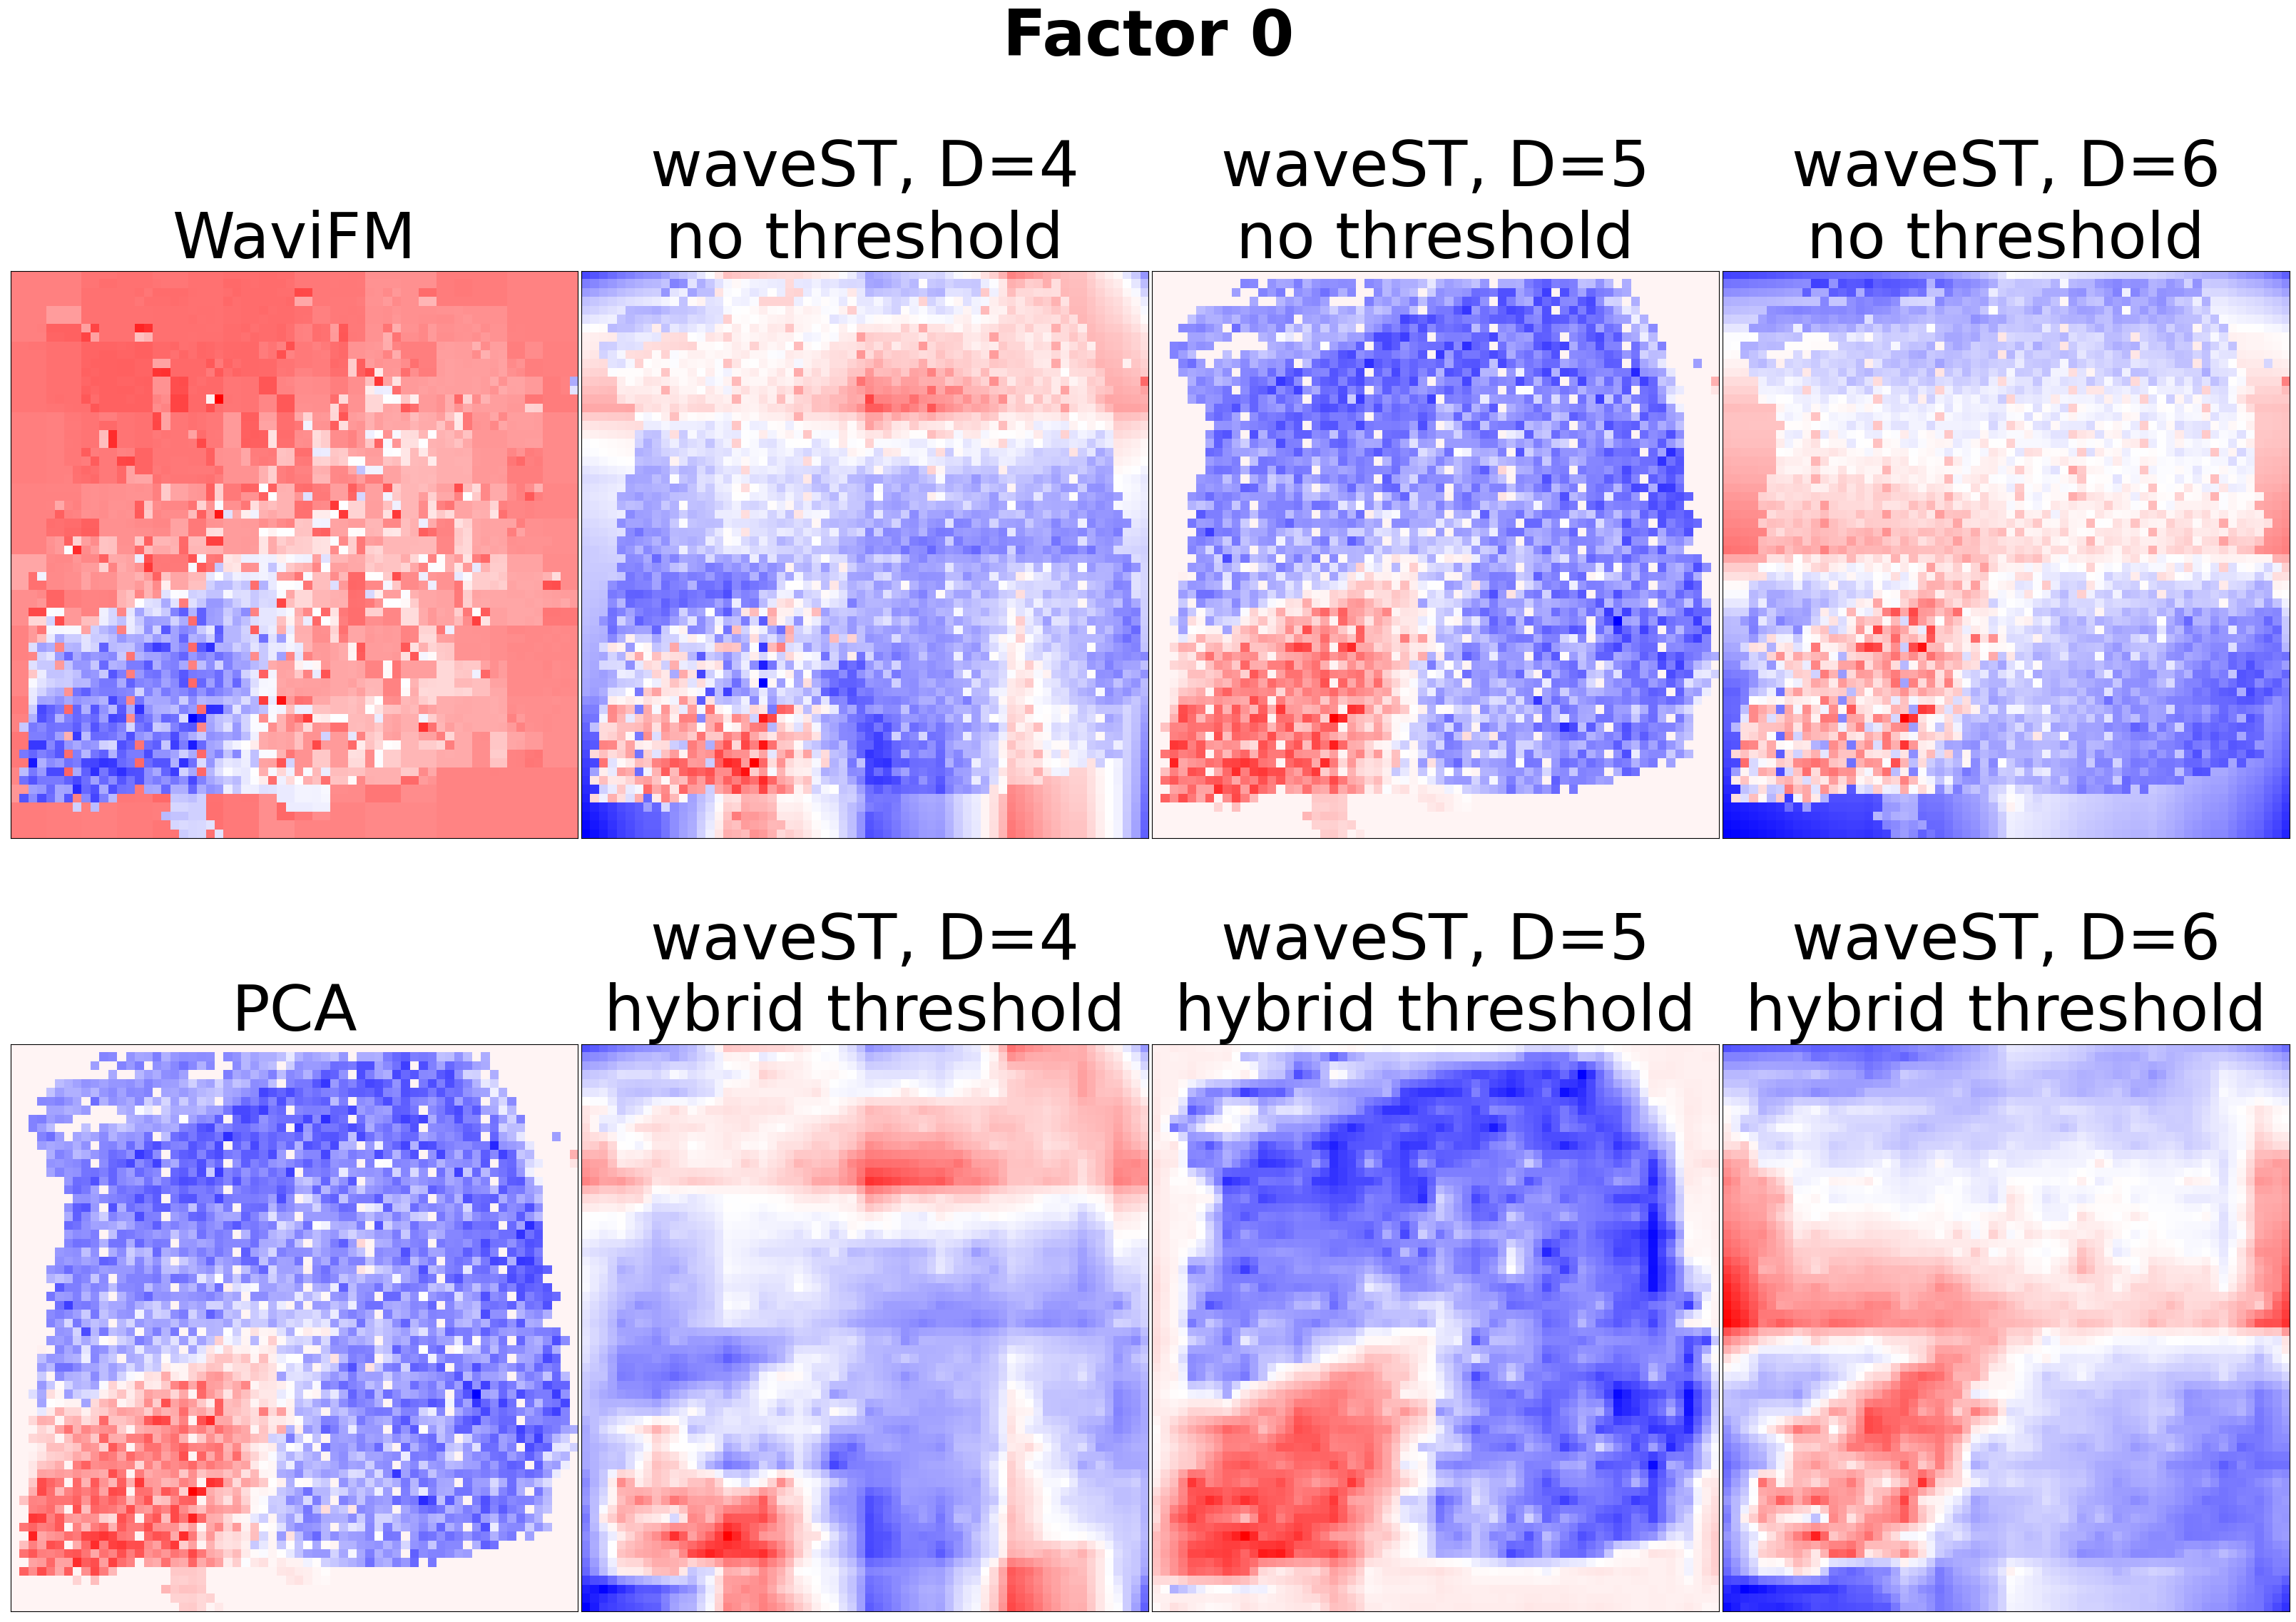

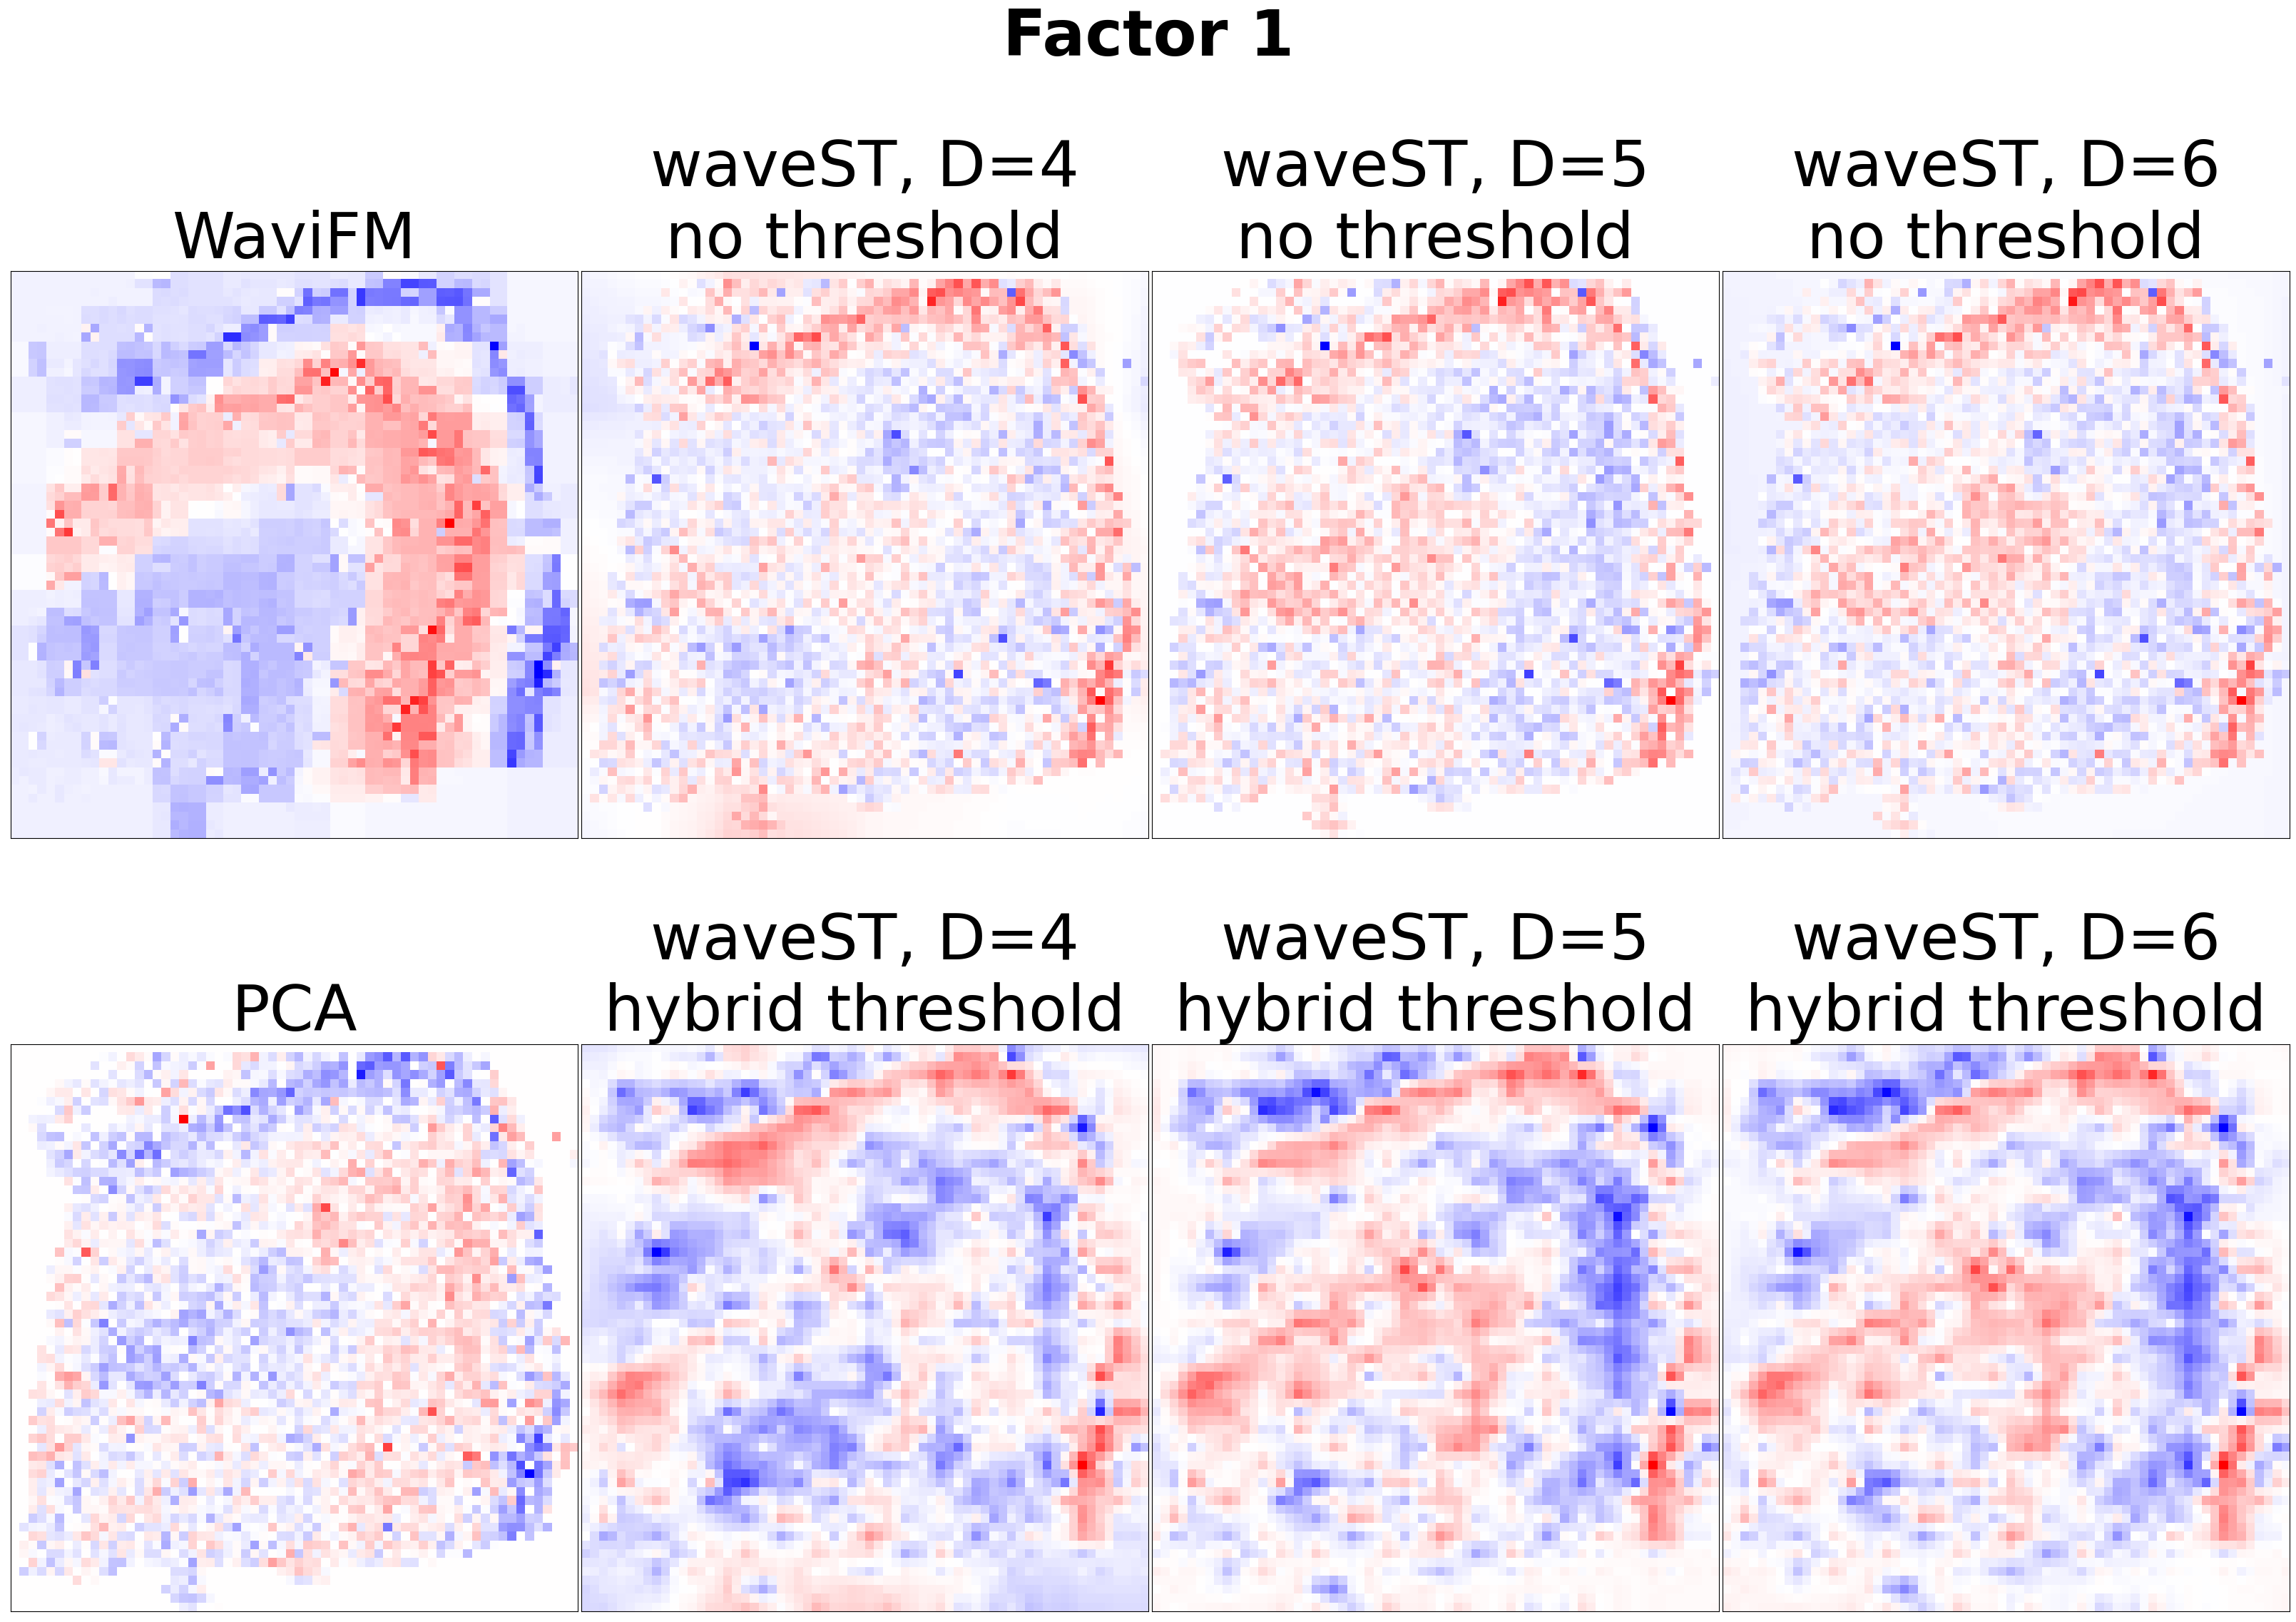

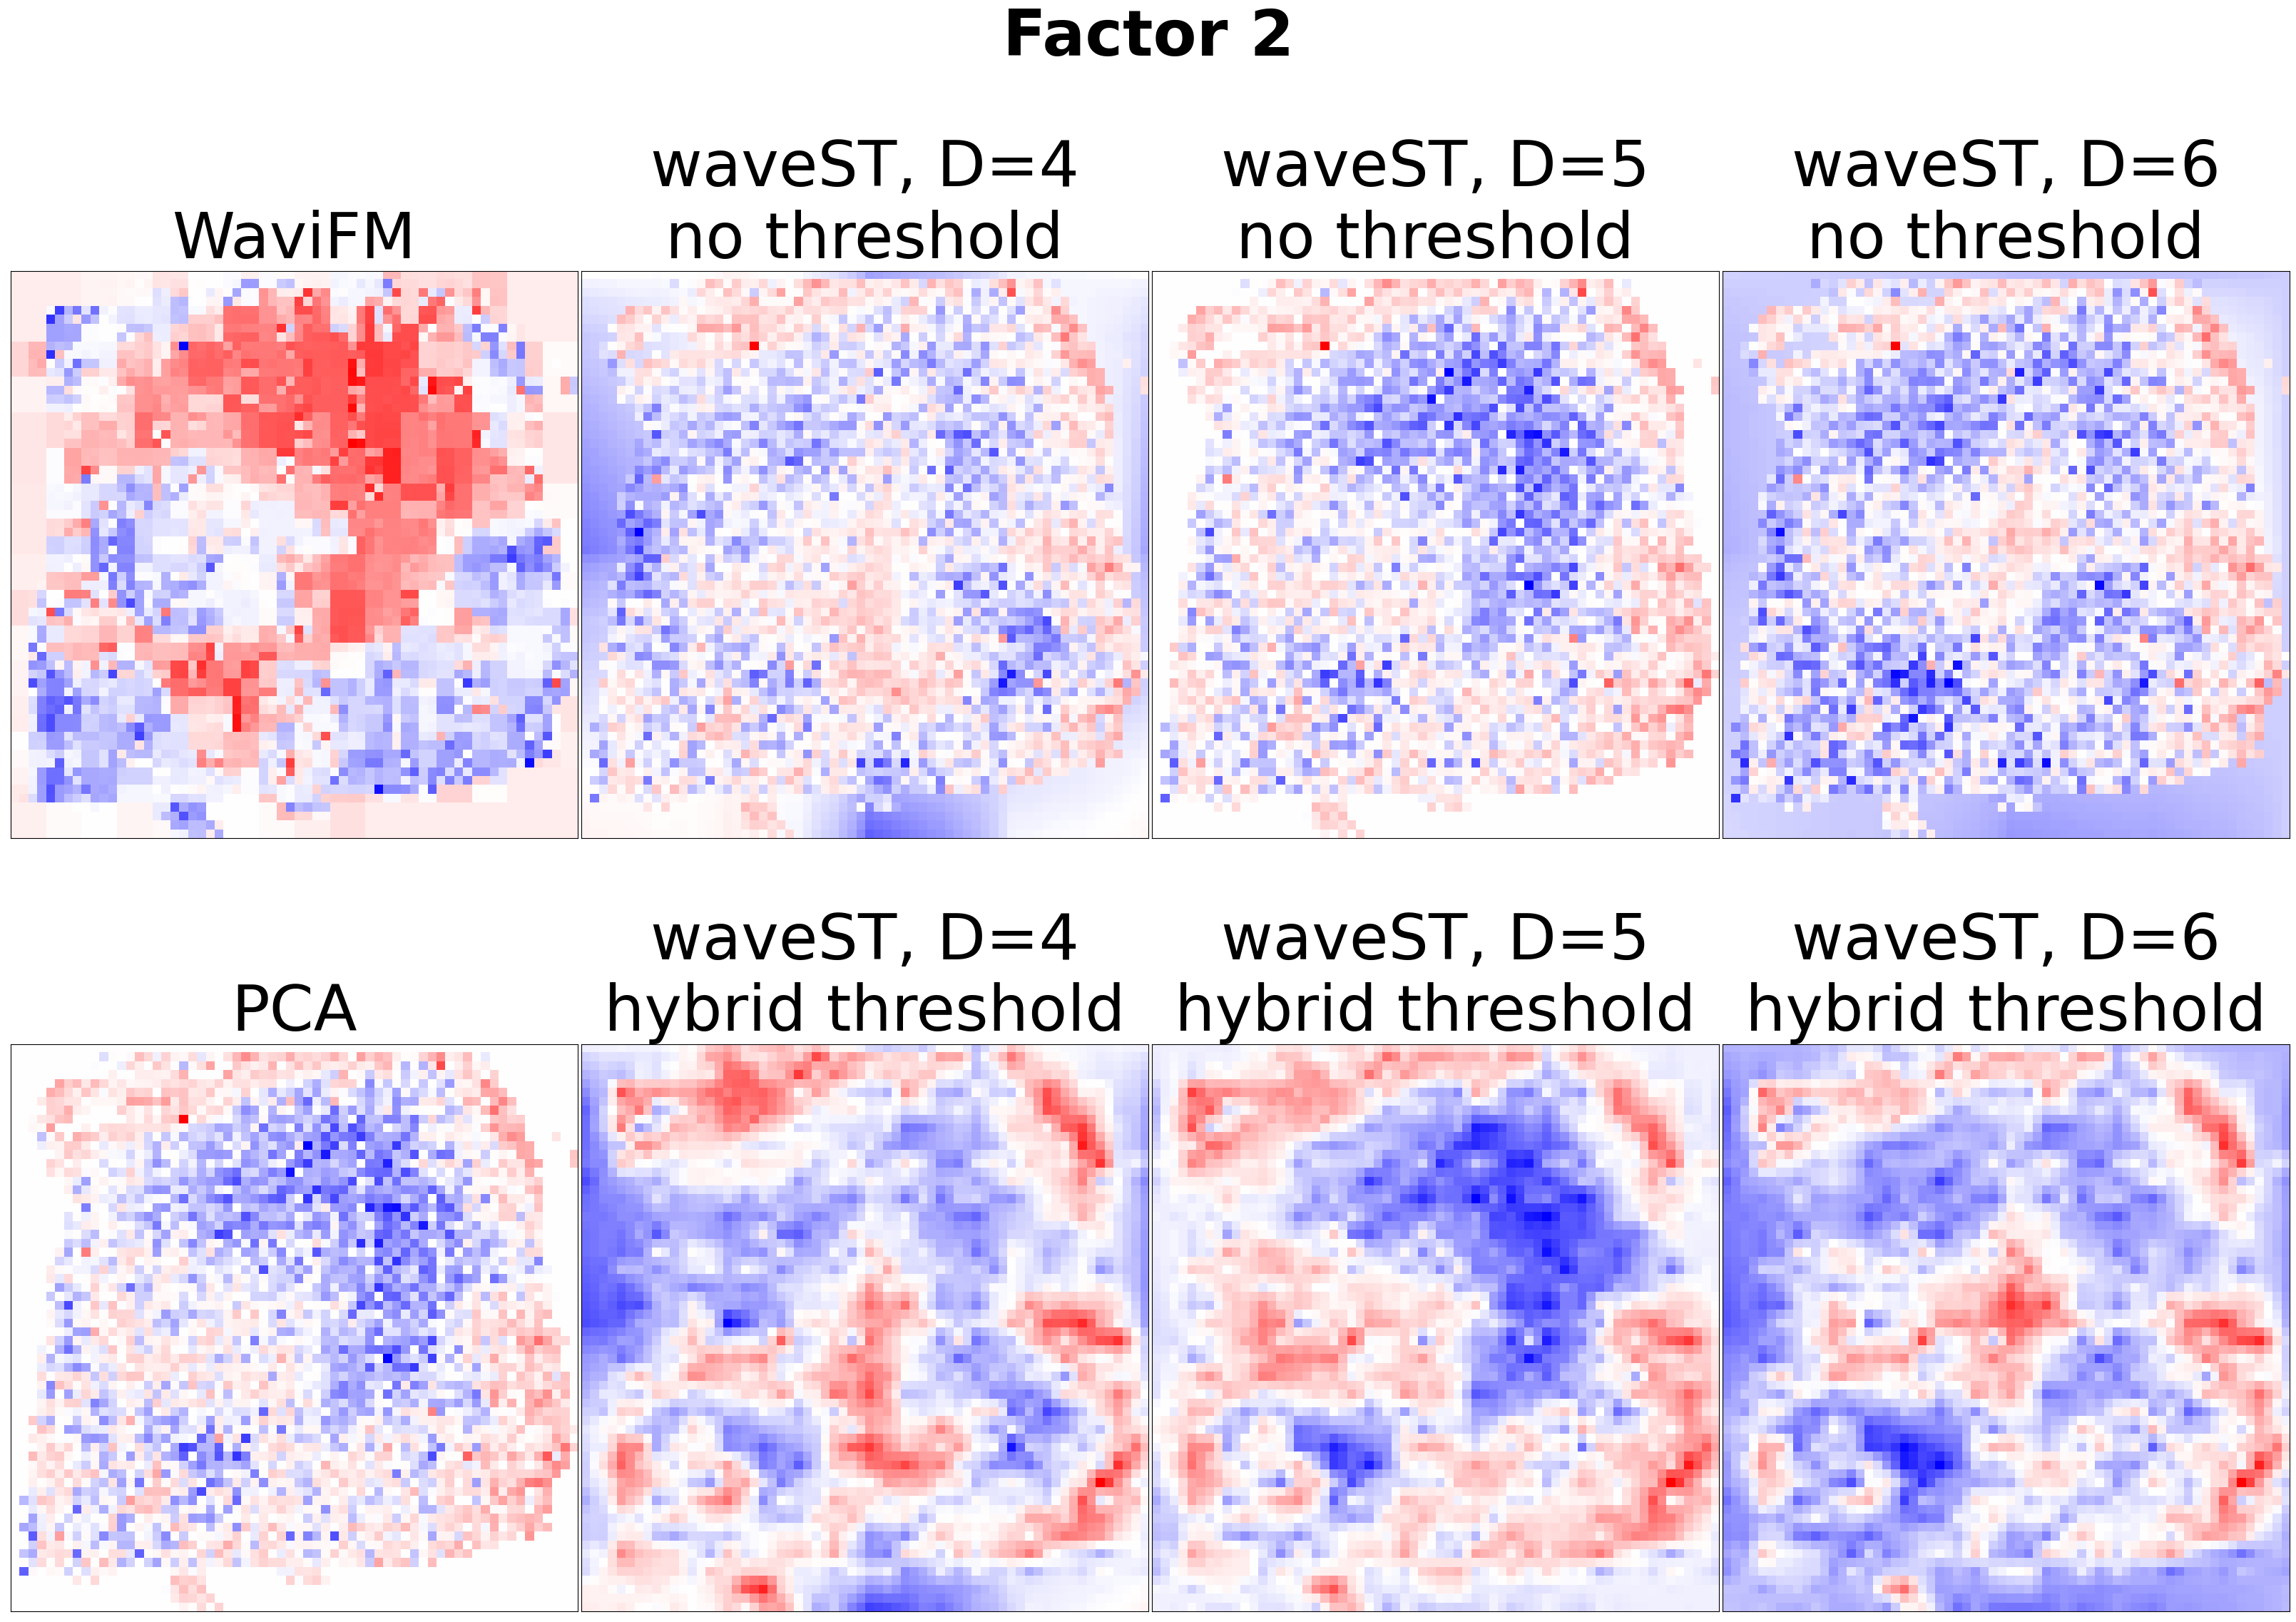

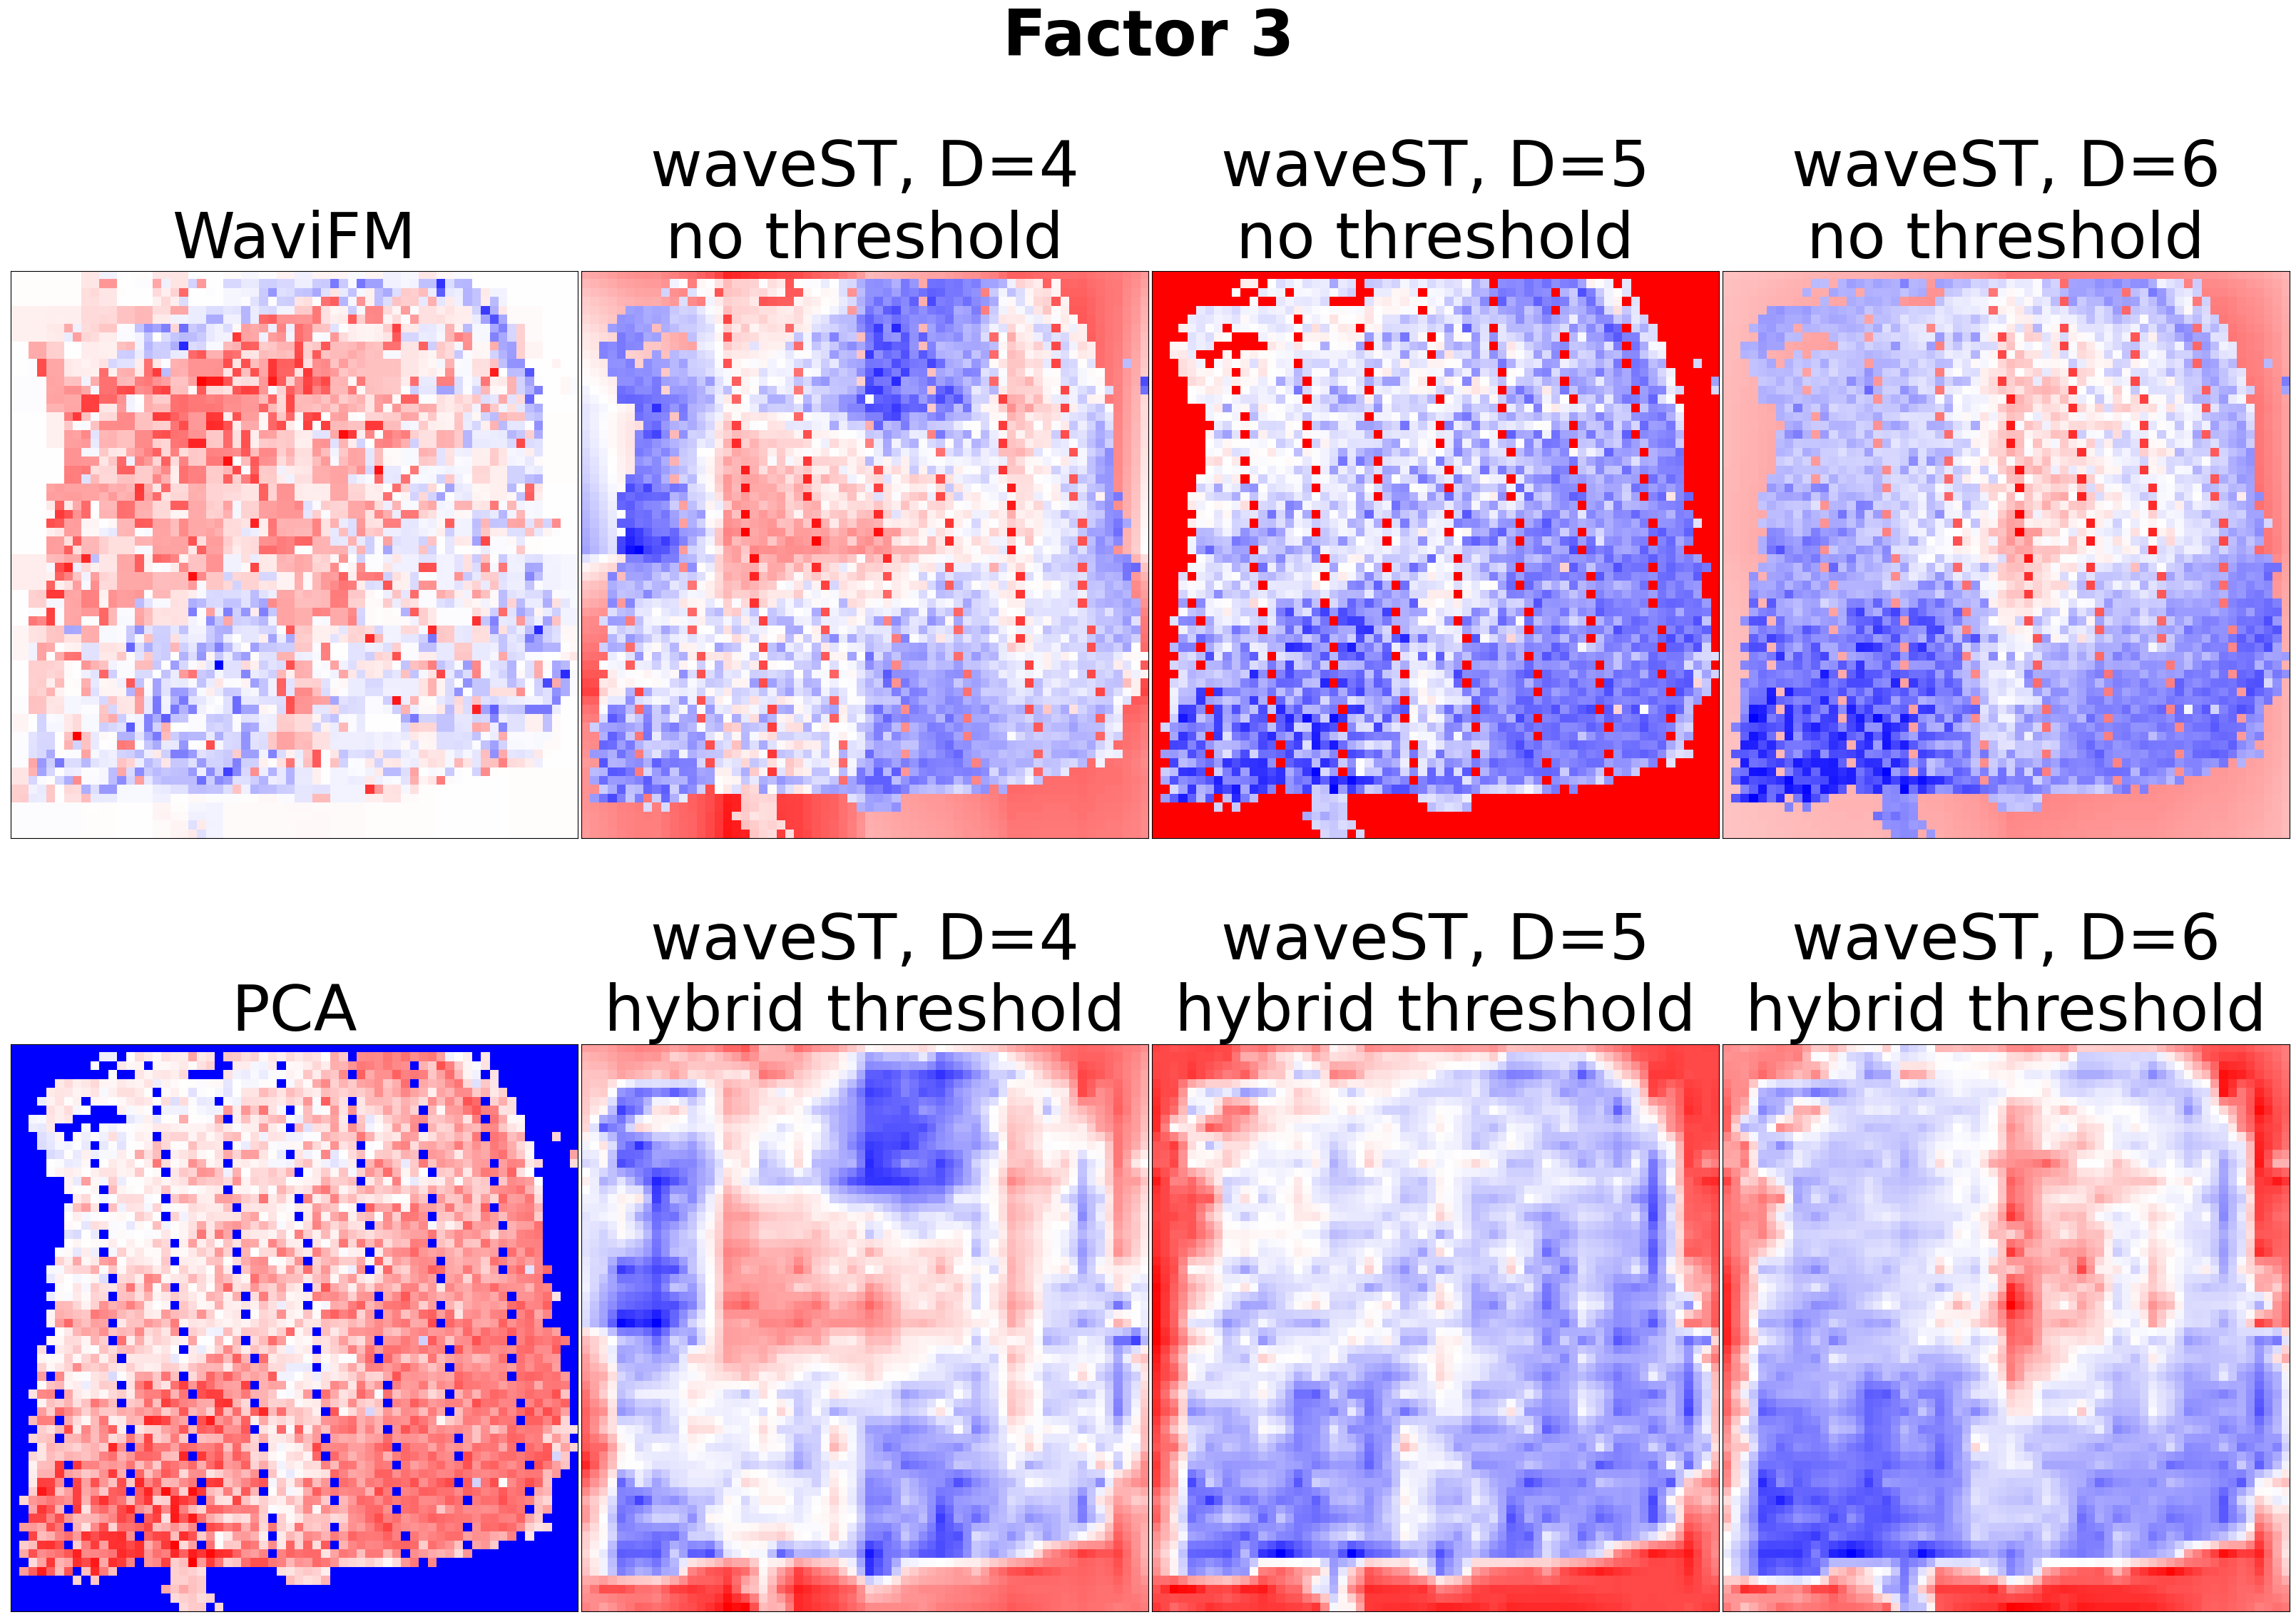

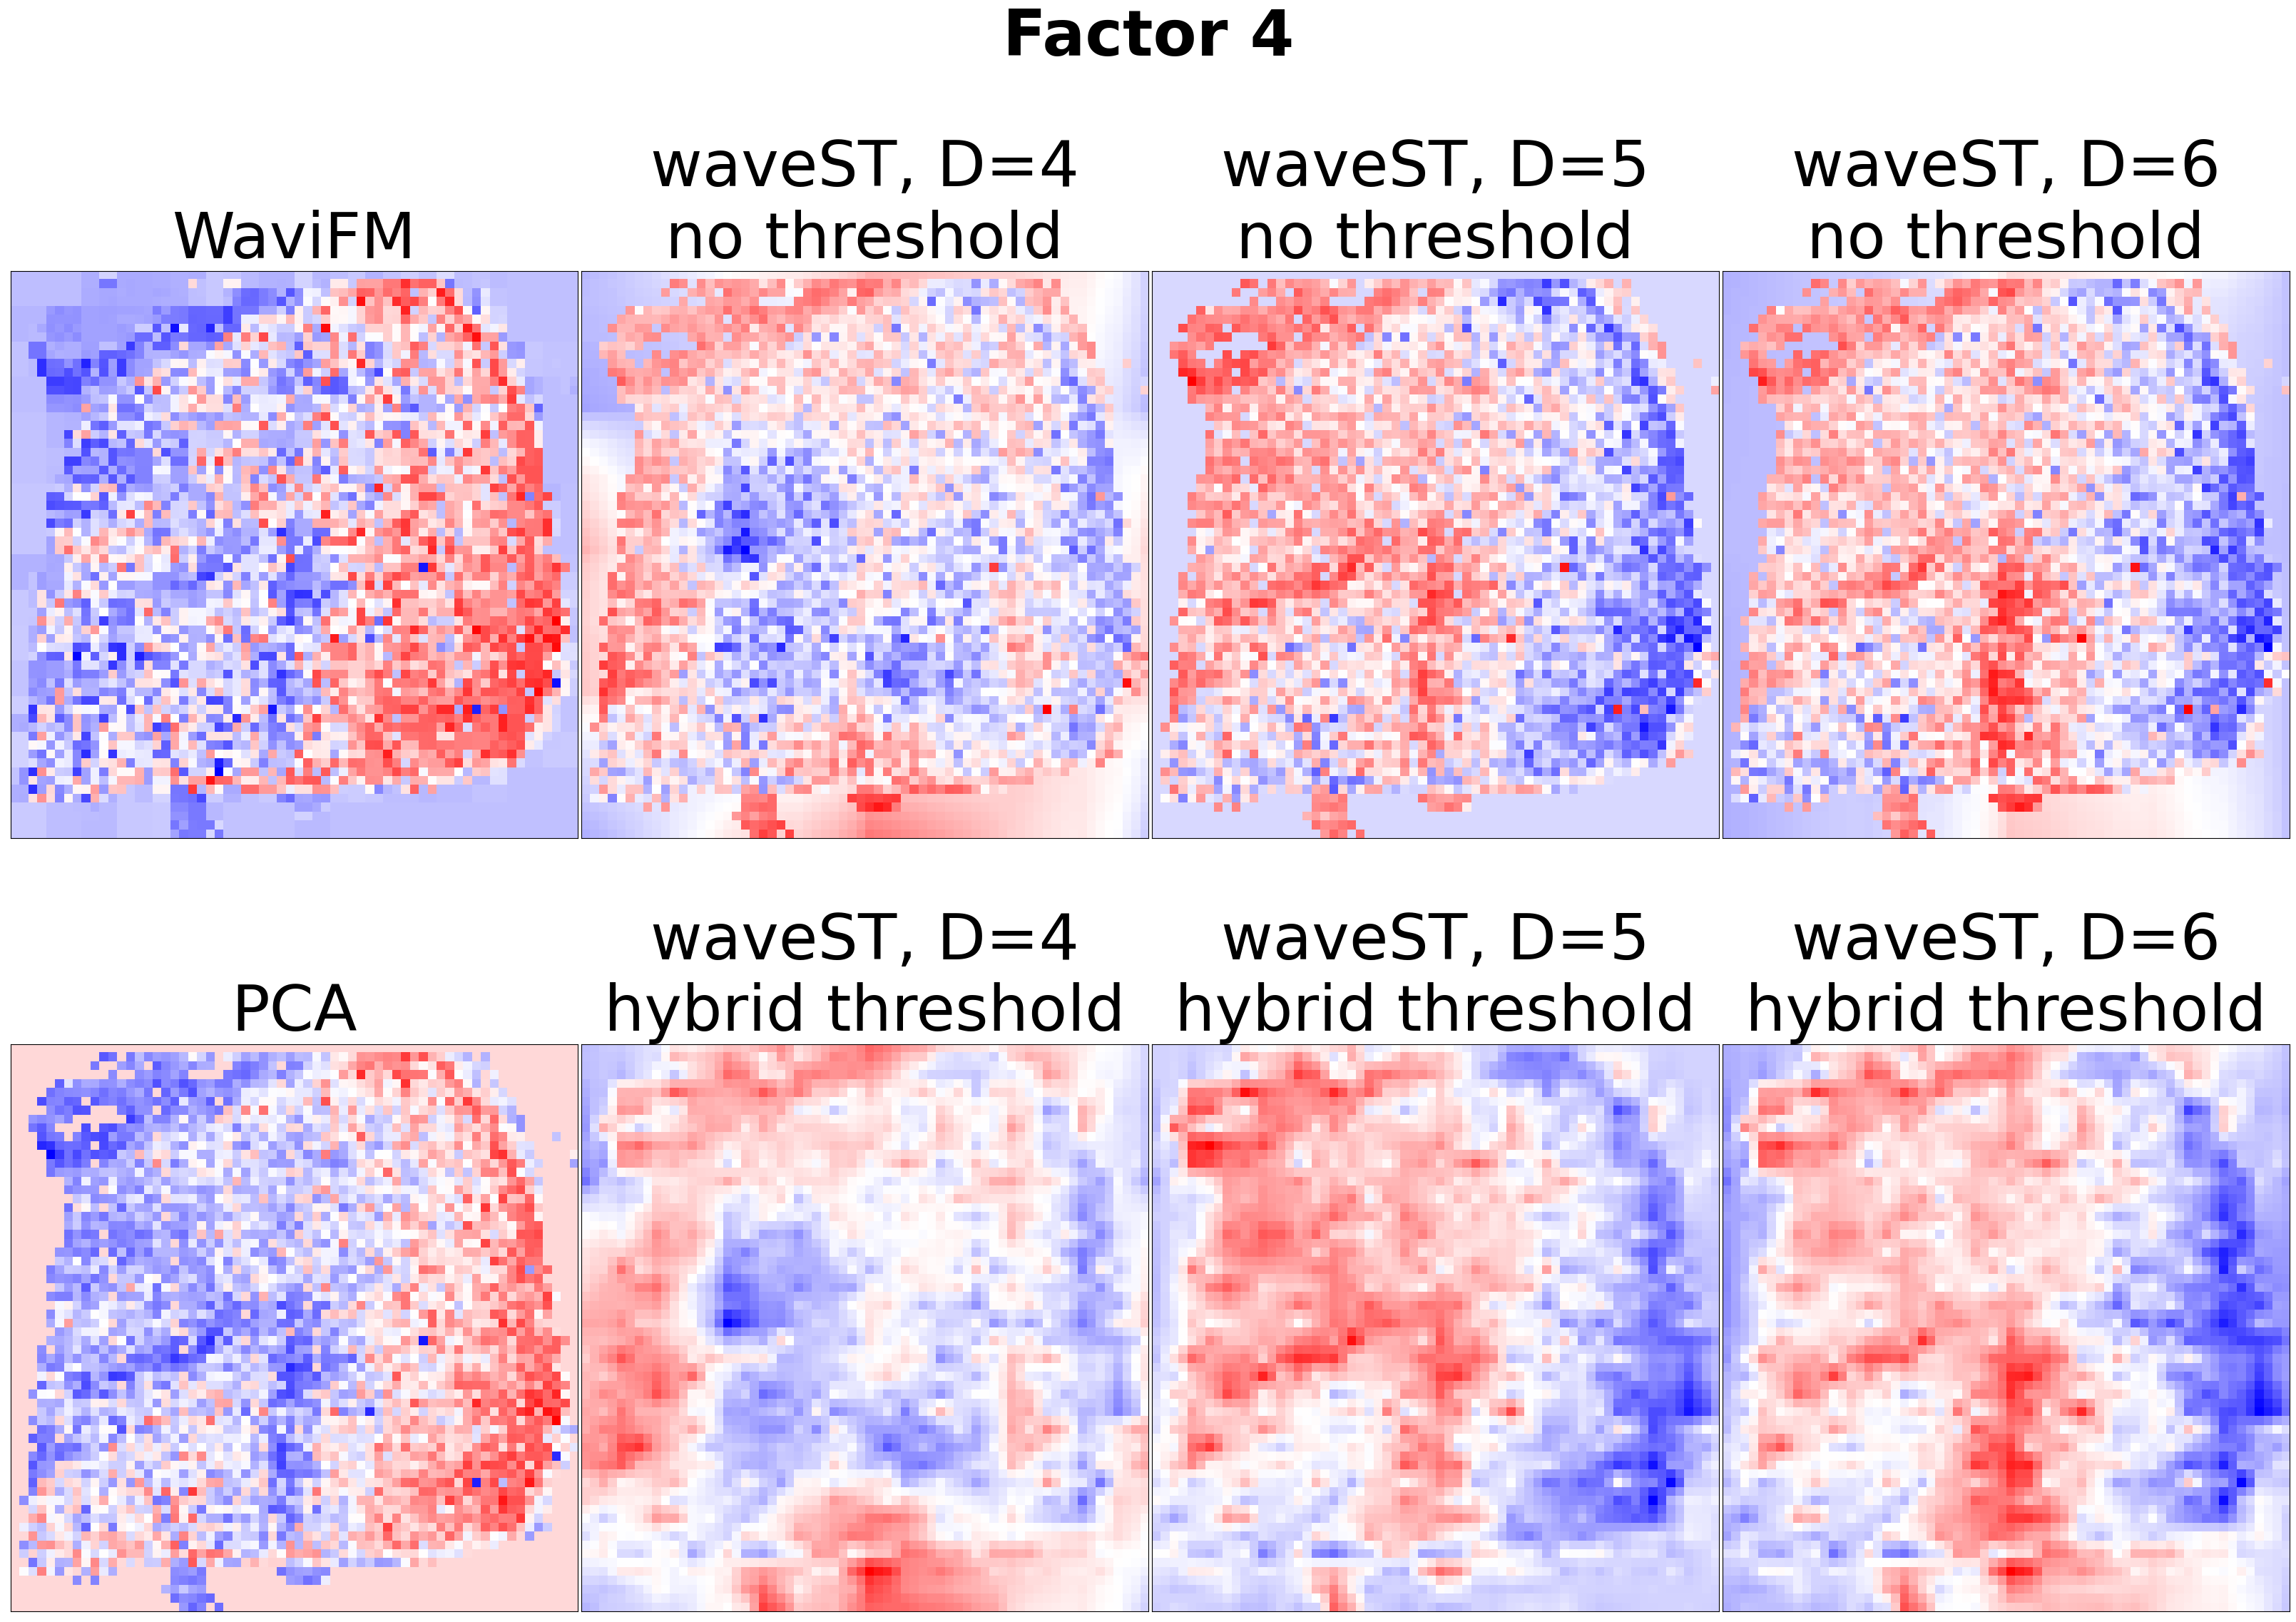

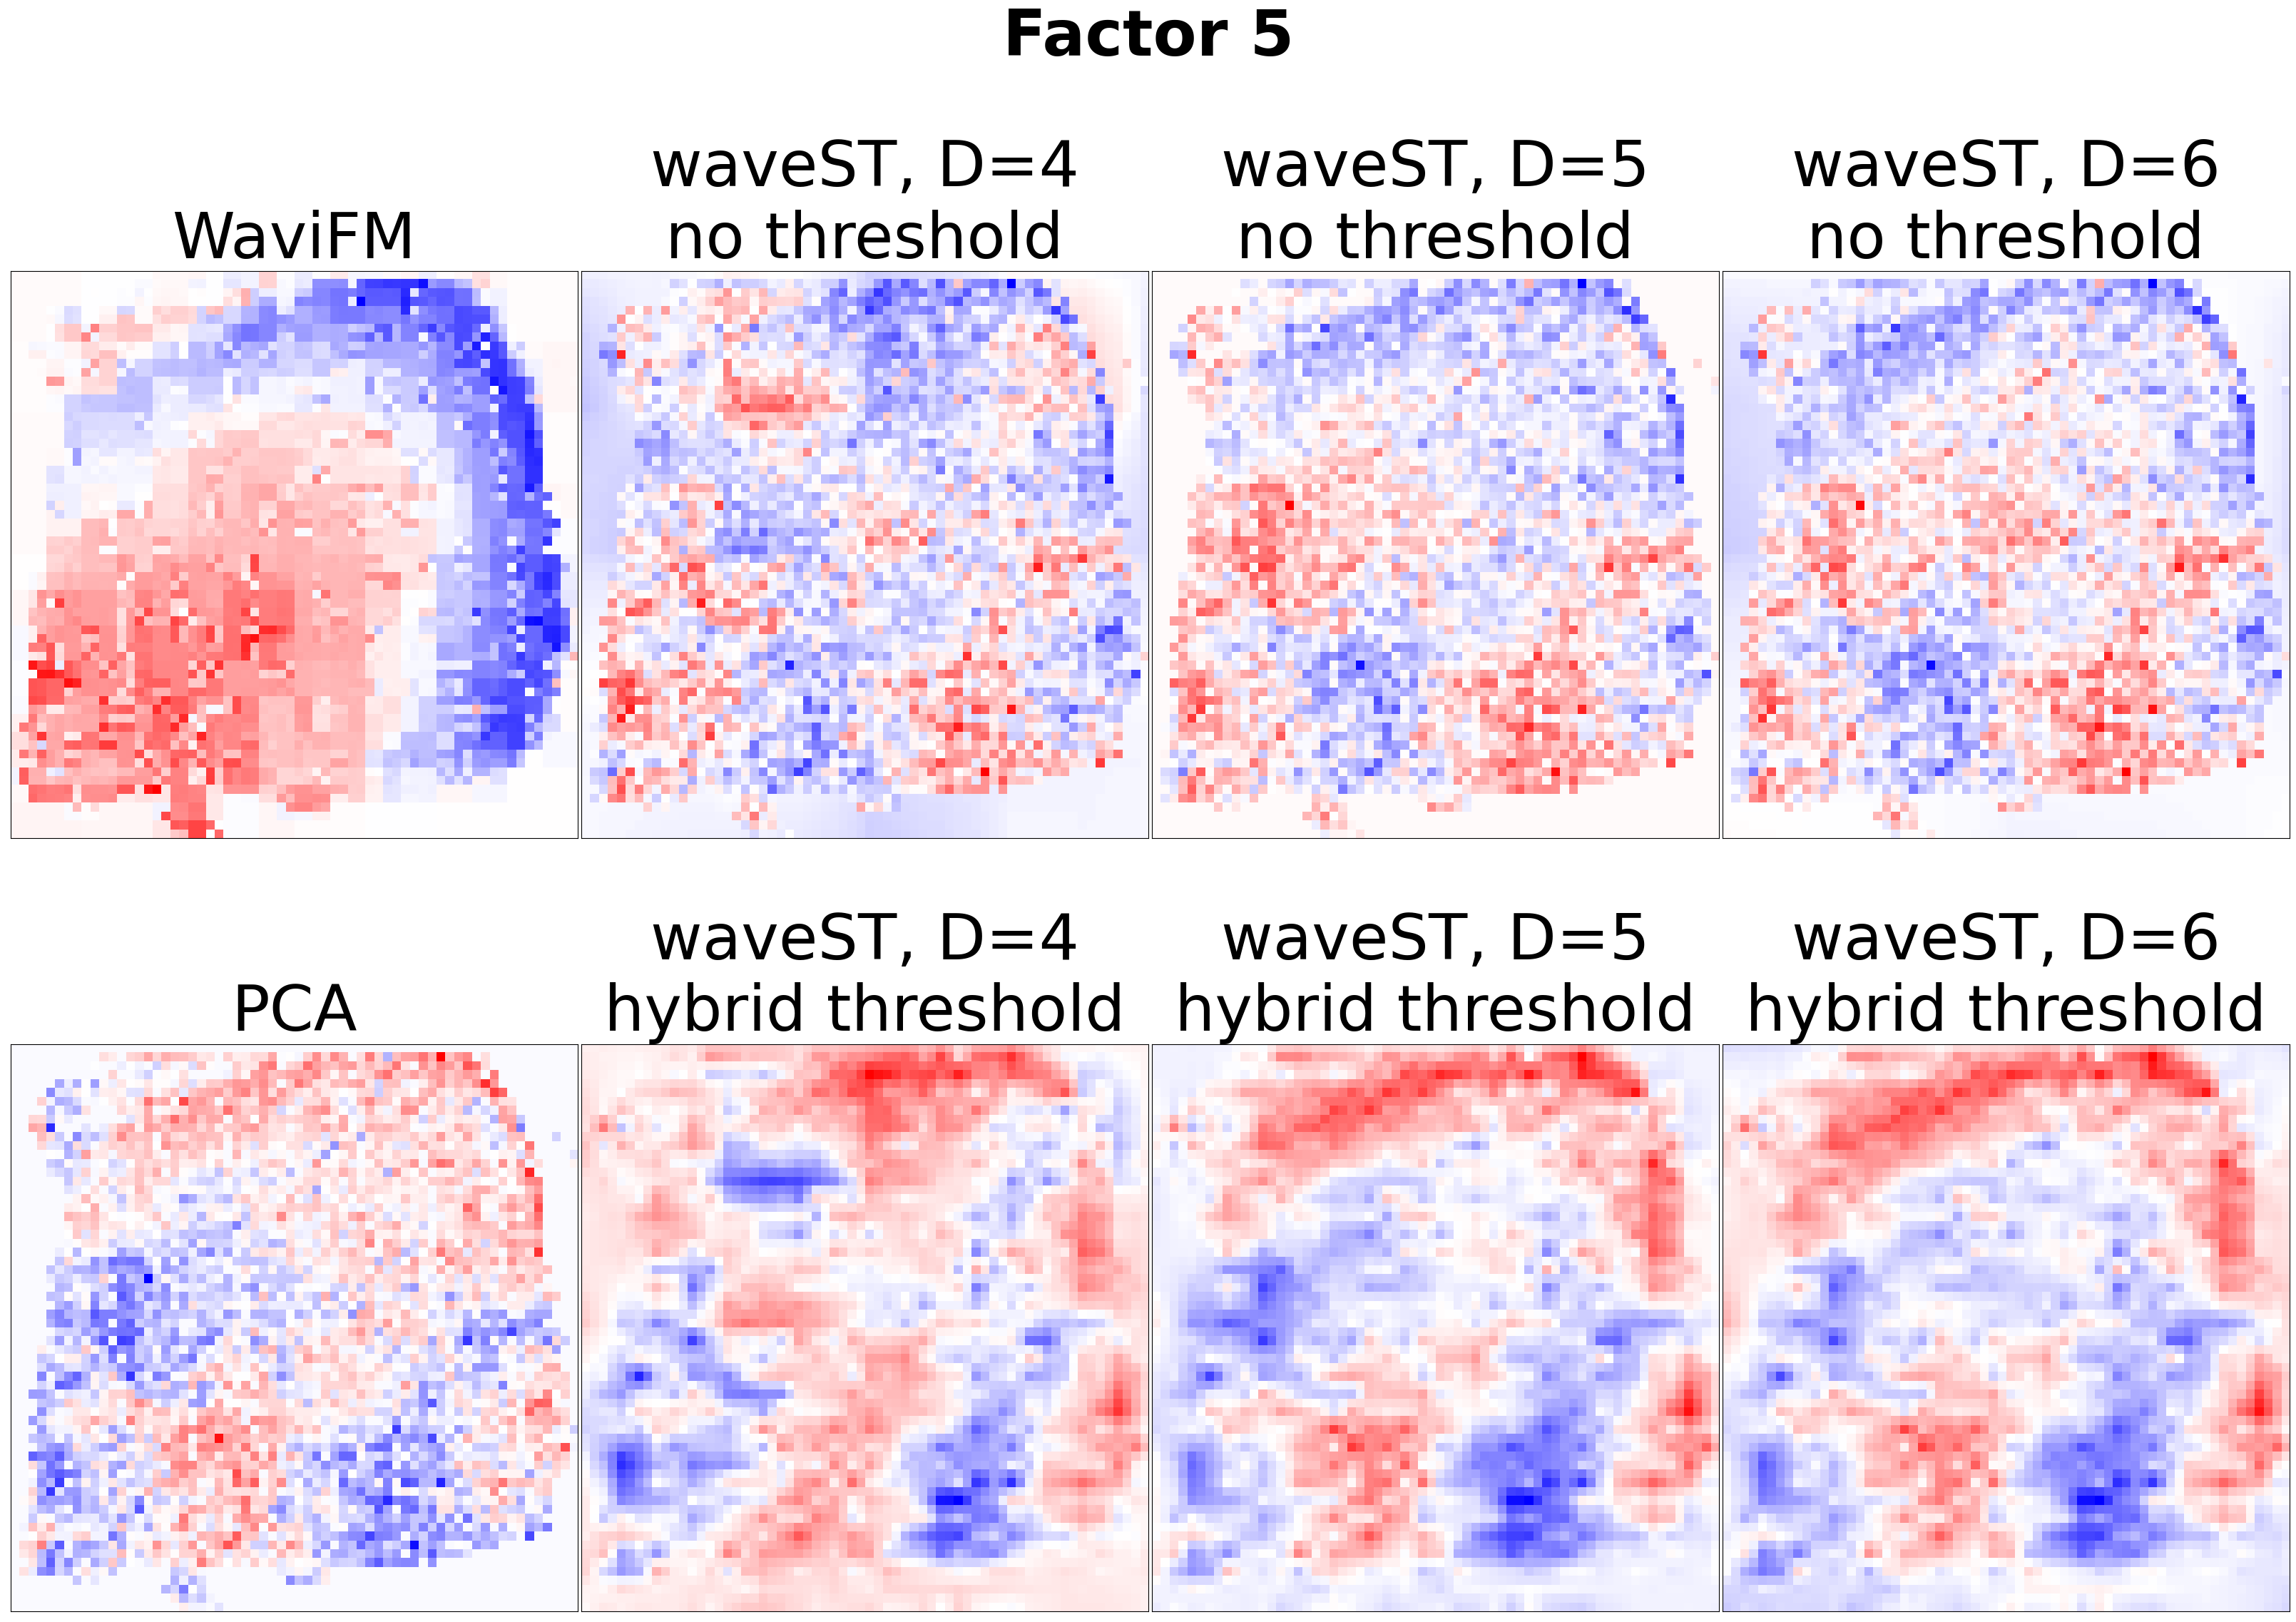

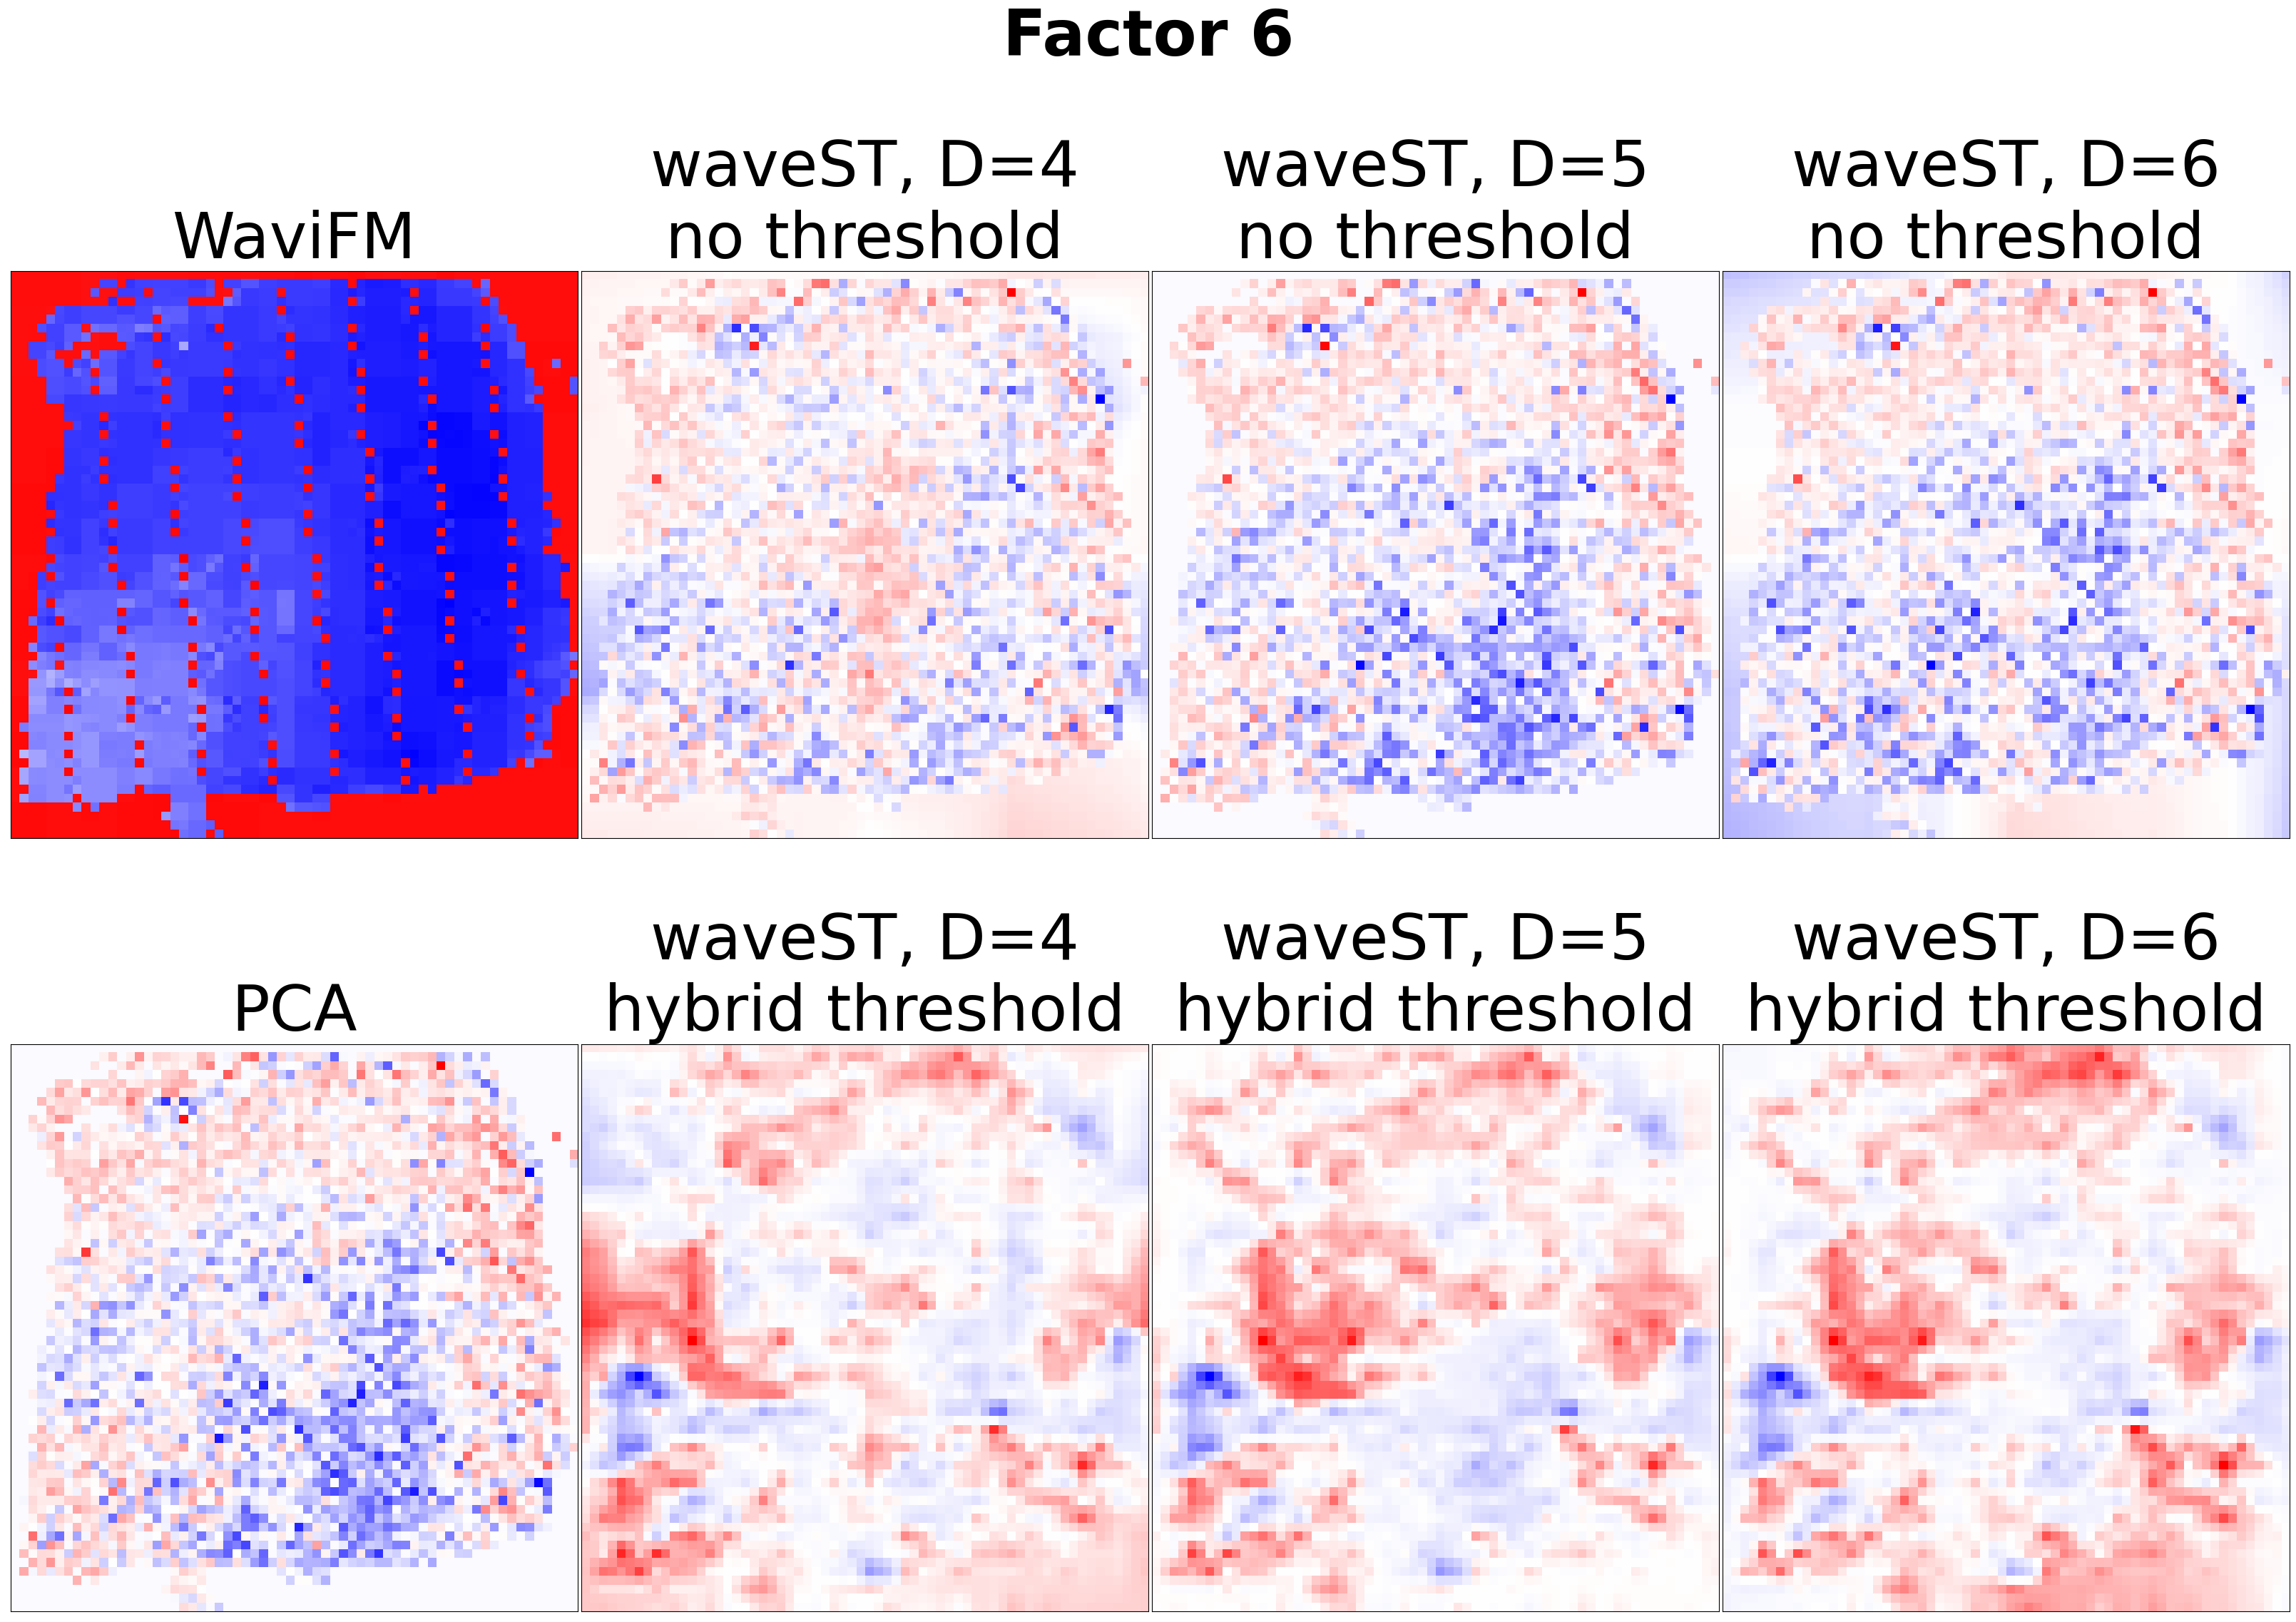

In [20]:
# Comparing L
L_list = [idwt_L_means, waveST_L_0_threshold, waveST_L_0_threshold_5, waveST_L_0_threshold_6,
          L_pca, waveST_L_hybrid, waveST_L_hybrid_5, waveST_L_hybrid_6]
L_title = ["WaviFM", "waveST, D=4\nno threshold", "waveST, D=5\nno threshold", "waveST, D=6\nno threshold",
           "PCA", "waveST, D=4\nhybrid threshold", "waveST, D=5\nhybrid threshold", "waveST, D=6\nhybrid threshold"]

for i in range(n_factors): # for each of the factors
    fig, axes = plt.subplots(2, 4, figsize=(32, 24))
    fig.suptitle(f"Factor {i}", fontsize=64, y=1.02, weight='bold')
    for m in range(len(L_list)): # for each of the methods
        ax = axes.flat[m]
        matrix = L_list[m][i]
        
        # Set norm for colouring
        flattened_matrix = np.array(matrix).flatten()
        matrix_min = flattened_matrix.min()
        matrix_max = flattened_matrix.max()
        norm_min = np.min((matrix_min, 0.0))
        norm_max = np.max((matrix_max, 0.0))
        norm_center = np.max((matrix_min, 0.0))
        if norm_max == norm_center and norm_min == norm_center:
            norm_min -= 1e-10
            norm_max += 1e-10
        if norm_min == norm_center:
            norm_min -= np.abs(norm_max - norm_center) / 10000
        if norm_max == norm_center:
            norm_max += np.abs(norm_min - norm_center) / 10000
        norm = TwoSlopeNorm(vmin=norm_min, vcenter=norm_center, vmax=norm_max)
        
        # Plot activites
        im = ax.imshow(matrix, cmap=rb_centred_color_map, norm=norm, interpolation="none")
        ax.set_title(L_title[m], fontsize=64)
        # ax.set_xlabel("Horizontal ordinate", fontsize=36)
        # ax.set_ylabel("Vertical ordinate", fontsize=36)
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_xticks(np.append(np.arange(0, 64, 8), 63))
        # ax.set_yticks(np.append(np.arange(0, 64, 8), 63))
    fig.tight_layout(pad=0)
        

### Comparing ARI for clustering based on inference factor activites

In [21]:
# Some preprocessing

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
rna['spatialLIBD_dummy'] = list(encoder.fit_transform(rna[['spatialLIBDCode']]))
grouped_dummy = rna.groupby(['grid_y', 'grid_x'])['spatialLIBD_dummy'].apply(lambda x: np.mean(np.vstack(x), axis=0))
fill_dummy_vector = np.zeros(grouped_dummy.iloc[0].shape[0])
grouped_dummy_reindexed = grouped_dummy.reindex(full_index, fill_value=fill_dummy_vector)
dummy_df = pd.DataFrame(grouped_dummy_reindexed.tolist(), index=grouped_dummy_reindexed.index)
dummy_column_names = [f'spatialLIBD_dummy_{i}' for i in range(dummy_df.shape[1])]
dummy_df.columns = dummy_column_names
dummy_df.index.names = ['y_index', 'x_index']

def get_max_index(row):
    if row.max() == 0:
        return -1
    return row.argmax()
dummy_cluster = dummy_df.apply(get_max_index, axis=1)

layer_colors_dummy = ['white', 'blue', 'darkorange', 'red', 'saddlebrown', 'orchid', 'darkkhaki', 'aqua']
layers_cmap_dummy = ListedColormap(layer_colors_dummy)

dummy_cluster_matrix = dummy_cluster.unstack()
dummy_cluster_array = dummy_cluster.unstack().values

# # Plot the cluster indices using imshow
# plt.figure(figsize=(4, 4))
# plt.imshow(dummy_cluster_matrix, cmap=layers_cmap_dummy, origin='lower')
# plt.colorbar(label='Cluster Index')
# plt.title('Cluster Map')
# plt.xlabel('x_index')
# plt.ylabel('y_index')
# plt.show()

In [22]:
from sklearn.mixture import GaussianMixture

# Function for performing Gaussian mixture cluster on factor activities

def gmm_cluster(L, n_clusters, random_state=None):
    flattened_L = [matrix.flatten() for matrix in L]
    X = np.column_stack(flattened_L)
    gmm = GaussianMixture(n_components=n_clusters, random_state=random_state, max_iter=1000, tol=0.00001)
    clusters = gmm.fit_predict(X)
    spatial_shape = L[0].shape
    cluster_matrix = clusters.reshape(spatial_shape)
    
    return cluster_matrix

In [23]:
from sklearn.metrics import adjusted_rand_score

N_CLUSTERS = 8
N_REPS = 100

wavifm_ari = []
pca_ari = []
wavest_ari = []
wavest_hyb_ari = []
wavest_5_ari = []
wavest_5_hyb_ari = []
wavest_6_ari = []
wavest_6_hyb_ari = []
for i in range(N_REPS):
    wavifm_cluster = gmm_cluster(idwt_L_means, N_CLUSTERS, random_state=i)
    pca_cluster = gmm_cluster(L_pca, N_CLUSTERS, random_state=i)
    wavest_cluster = gmm_cluster(waveST_L_0_threshold, N_CLUSTERS, random_state=i)
    wavest_hyb_cluster = gmm_cluster(waveST_L_hybrid, N_CLUSTERS, random_state=i)
    wavest_5_cluster = gmm_cluster(waveST_L_0_threshold_5, N_CLUSTERS, random_state=i)
    wavest_5_hyb_cluster = gmm_cluster(waveST_L_hybrid_5, N_CLUSTERS, random_state=i)
    wavest_6_cluster = gmm_cluster(waveST_L_0_threshold_6, N_CLUSTERS, random_state=i)
    wavest_6_hyb_cluster = gmm_cluster(waveST_L_hybrid_6, N_CLUSTERS, random_state=i)
    
    wavifm_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavifm_cluster.flatten())
    pca_score = adjusted_rand_score(dummy_cluster_array.flatten(), pca_cluster.flatten())
    wavest_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavest_cluster.flatten())
    wavest_hyb_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavest_hyb_cluster.flatten())
    wavest_5_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavest_5_cluster.flatten())
    wavest_5_hyb_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavest_5_hyb_cluster.flatten())
    wavest_6_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavest_6_cluster.flatten())
    wavest_6_hyb_score = adjusted_rand_score(dummy_cluster_array.flatten(), wavest_6_hyb_cluster.flatten())
    
    wavifm_ari.append(wavifm_score)
    pca_ari.append(pca_score)
    wavest_ari.append(wavest_score)
    wavest_hyb_ari.append(wavest_hyb_score)
    wavest_5_ari.append(wavest_5_score)
    wavest_5_hyb_ari.append(wavest_5_hyb_score)
    wavest_6_ari.append(wavest_6_score)
    wavest_6_hyb_ari.append(wavest_6_hyb_score)
    
ari_cols = [L_title[i] for i in (0,4,1,5,2,6,3,7)]
ari = pd.DataFrame(list(zip(wavifm_ari, pca_ari, wavest_ari, wavest_hyb_ari, wavest_5_ari, wavest_5_hyb_ari, wavest_6_ari, wavest_6_hyb_ari)), columns=ari_cols)

In [24]:
# for col in ari_cols:
#     print(col)
#     print(ari[col].argmax())
#     print(ari[col].max())

In [25]:
ari_means = ari.mean(axis=0)
ari_medians = ari.median(axis=0)
pd.DataFrame({
    'Mean ARI': ari_means,
    'Median ARI': ari_medians
}, index=ari.columns)

,Mean ARI,Median ARI
WaviFM,0.594894,0.602554
PCA,0.523472,0.524540
"waveST, D=4\nno threshold",0.226467,0.218635
"waveST, D=4\nhybrid threshold",0.119586,0.114624
"waveST, D=5\nno threshold",0.523158,0.525377
"waveST, D=5\nhybrid threshold",0.320532,0.321831
"waveST, D=6\nno threshold",0.372601,0.340235
"waveST, D=6\nhybrid threshold",0.238983,0.226568


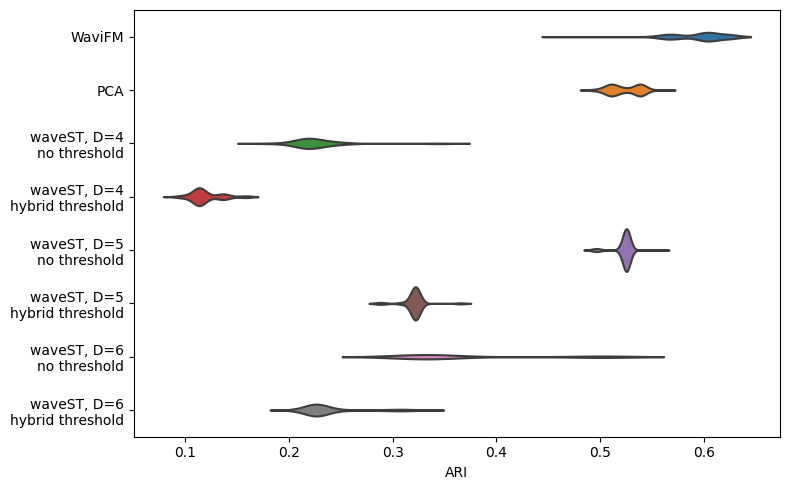

In [26]:
# Create a horizontal violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(data=ari, orient='h', inner=None)
plt.xlabel('ARI')
plt.tight_layout()
plt.show()

### Comparing clustering results for the methods

Cluster chosen for each method was the one with the highest ARI

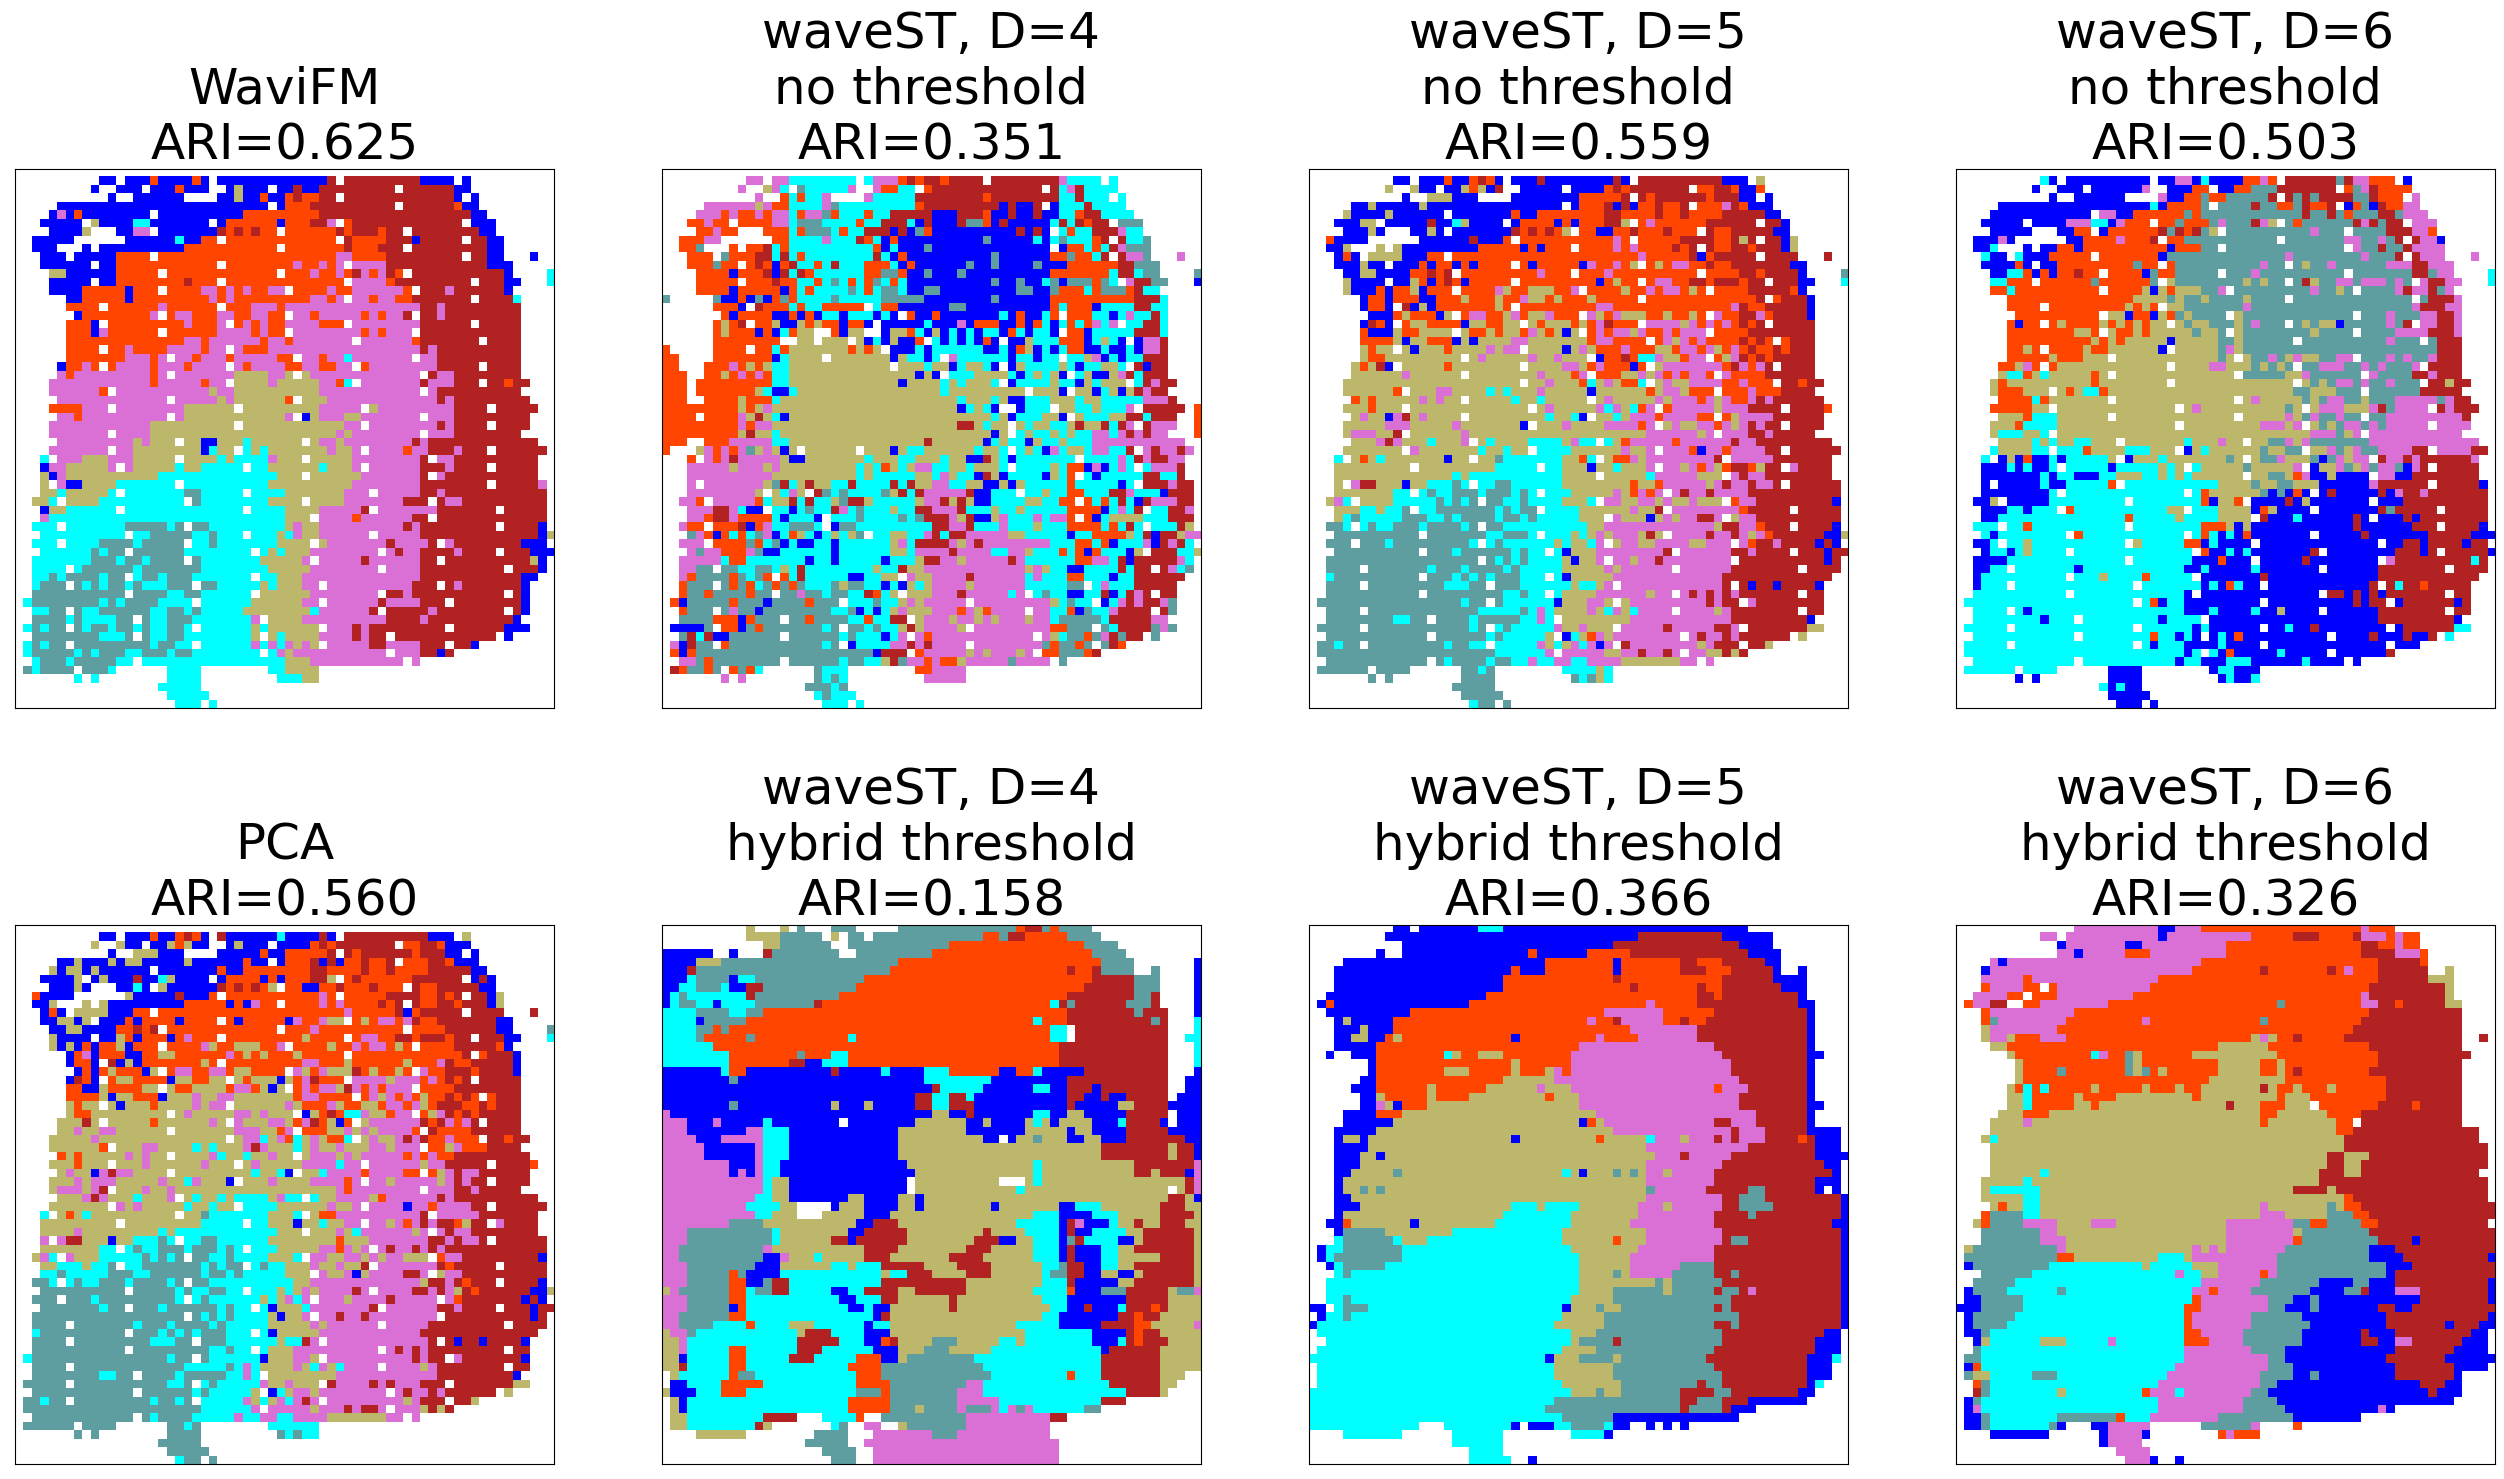

In [27]:
layer_colors_wavifm = ['orangered', 'cadetblue', 'white', 'orchid', 'firebrick', 'aqua', 'darkkhaki', 'blue']
layer_colors_pca = ['orchid', 'white', 'cadetblue', 'darkkhaki', 'blue', 'aqua', 'firebrick', 'orangered']
layer_colors_wavest = ['firebrick', 'blue', 'orangered', 'orchid', 'white', 'cadetblue', 'darkkhaki', 'aqua']
layer_colors_wavest_hyb = ['white', 'darkkhaki', 'cadetblue', 'aqua', 'blue', 'firebrick', 'orchid', 'orangered']
layer_colors_wavest_5 = ['orangered', 'blue', 'white', 'firebrick', 'cadetblue', 'orchid', 'aqua', 'darkkhaki']
layer_colors_wavest_5_hyb = ['orchid', 'cadetblue', 'white', 'blue', 'firebrick', 'darkkhaki', 'aqua', 'orangered']
layer_colors_wavest_6 = ['blue', 'aqua', 'darkkhaki', 'firebrick', 'cadetblue', 'orchid', 'white', 'orangered']
layer_colors_wavest_6_hyb = ['orangered', 'orchid', 'white', 'darkkhaki', 'blue', 'firebrick', 'cadetblue', 'aqua']
assert len(set(layer_colors_wavifm)) == N_CLUSTERS
assert len(set(layer_colors_pca)) == N_CLUSTERS
assert len(set(layer_colors_wavest)) == N_CLUSTERS
assert len(set(layer_colors_wavest_hyb)) == N_CLUSTERS
assert len(set(layer_colors_wavest_5)) == N_CLUSTERS
assert len(set(layer_colors_wavest_5_hyb)) == N_CLUSTERS
assert len(set(layer_colors_wavest_6)) == N_CLUSTERS
assert len(set(layer_colors_wavest_6_hyb)) == N_CLUSTERS
cmap_wavifm = ListedColormap(layer_colors_wavifm)
cmap_pca = ListedColormap(layer_colors_pca)
cmap_wavest = ListedColormap(layer_colors_wavest)
cmap_wavest_hyb = ListedColormap(layer_colors_wavest_hyb)
cmap_wavest_5 = ListedColormap(layer_colors_wavest_5)
cmap_wavest_5_hyb = ListedColormap(layer_colors_wavest_5_hyb)
cmap_wavest_6 = ListedColormap(layer_colors_wavest_6)
cmap_wavest_6_hyb = ListedColormap(layer_colors_wavest_6_hyb)
cmap_list = [cmap_wavifm, cmap_wavest, cmap_wavest_5, cmap_wavest_6,
             cmap_pca, cmap_wavest_hyb, cmap_wavest_5_hyb, cmap_wavest_6_hyb]

fig, axes = plt.subplots(2, 4, figsize=(32, 18))
for m, (L_activities, title, cmap) in enumerate(zip(L_list, L_title, cmap_list)):
    ax = axes.flat[m]
    gmm_good_state = ari[title].argmax()
    result_cluster = gmm_cluster(L_activities, N_CLUSTERS, random_state=gmm_good_state)
    ari_score = adjusted_rand_score(dummy_cluster_array.flatten(), result_cluster.flatten())
    im = ax.imshow(result_cluster, cmap=cmap, aspect='equal', origin="lower")
    ax.set_title(f'{title}\nARI={ari_score:.3f}', fontsize=36)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Example for WaviFM differential gene expression (DEG)

In [28]:
factor_id = 0 # Factor to try doing DEG on (as in, extract strongly expressed genes for this factor)
F_for_factor_id = pd.Series(F_means[factor_id])

In [29]:
# Get 4 smallest values of factor loadings
active_genes = F_for_factor_id.nsmallest(4).index.sort_values().to_numpy()
active_genes

array([ 300,  419,  596, 1804], dtype=int64)

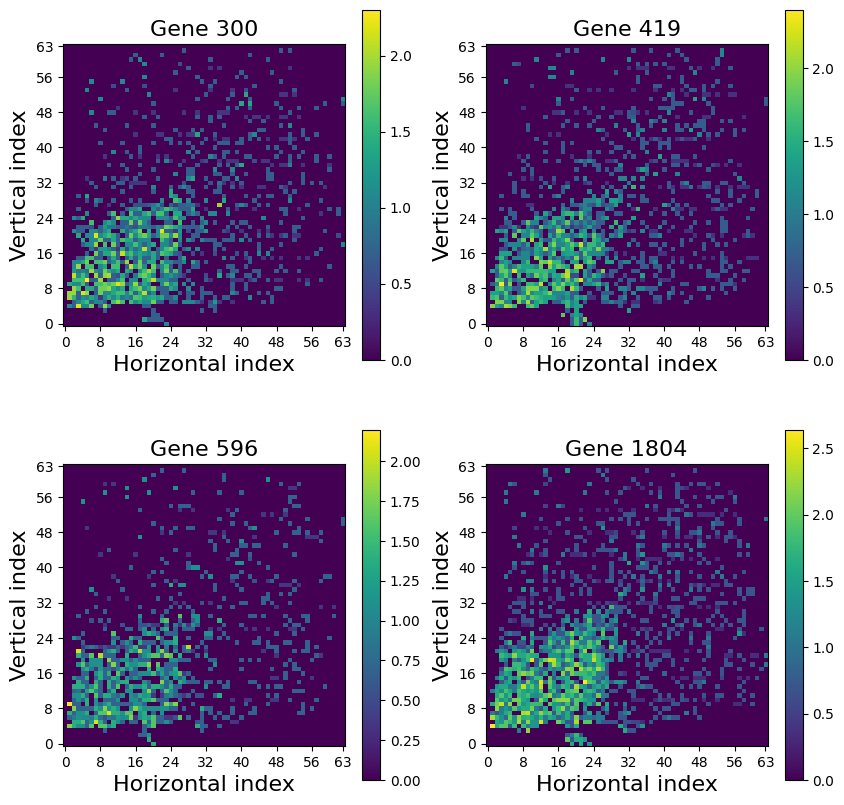

In [30]:
# Plot post-aggregation (in to boxes), pre-standardardisation (to 0 mean and 1 variance) gene expressions for these active genes
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for id, g in enumerate(active_genes):
    x = id%2
    y = id//2
    aggregated_gene = grid_rna.iloc[:, g].unstack(level='x_index')
    im = axes[y,x].imshow(aggregated_gene.values, cmap='viridis', aspect='equal', 
                        origin='lower')
    fig.colorbar(im, ax=axes[y,x])
    axes[y,x].set_title(f'Gene {g}', fontsize=16)
    axes[y,x].set_xlabel('Horizontal index', fontsize=16)
    axes[y,x].set_ylabel('Vertical index', fontsize=16)
    axes[y,x].set_xticks(np.append(np.arange(0, 63 + 1, 8), 63))
    axes[y,x].set_yticks(np.append(np.arange(0, 63 + 1, 8), 63))
plt.show()